# Debit Card Fraud Detection

# Import Dependencies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, fcluster

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data Profiling

In [2]:
df = pd.read_csv("/Users/raghav/Downloads/bank_transactions_data_2.csv")
df.head()

TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81              1   
1           68             Doctor                  141              1   
2           19            Student                   56              1   
3           26            Student                   25              1   
4           26            Student                  198              1   

   AccountBalance PreviousTransactionDate  
0         5112.21     2024-11-04 08:08:08  
1        13758.91     2024-11-04 08:09:35  
2         1122.35     2024-11-04 08:07:04  
3         8569.06     2024-11-04 08:09:06  
4         7429.40     2024-11-04 08:06:39

Remove Customer Demographic Data

In [3]:
demographic_columns = ['CustomerAge', 'CustomerOccupation']
df = df.drop(columns=demographic_columns, errors='ignore')
df.head()

TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   TransactionDuration  LoginAttempts  AccountBalance PreviousTransactionDate  
0                   81              1         5112.21     2024-11-04 08:08:08  
1                  141              1        13758.91     2024-11-04 08:09:35  
2                   56              1         1122.35     2024-11-04 08:07:04  
3                   25              1         8569.06     2024-11-04 08:09:06  
4                  198              1         7429.40     2024-11-04 08:06:39

Filtering the transactions made using Debit card

In [4]:
debit_transactions = df[df['TransactionType'] == 'Debit']
data = debit_transactions
data.head()

TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
5      TX000006   AC00393              92.15  2023-04-03 17:15:01   

  TransactionType       Location DeviceID      IP Address MerchantID Channel  \
0           Debit      San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit        Houston  D000051     13.149.61.4       M052     ATM   
2           Debit           Mesa  D000235  215.97.143.157       M009  Online   
3           Debit        Raleigh  D000187  200.13.225.150       M002  Online   
5           Debit  Oklahoma City  D000579  117.67.192.211       M054     ATM   

   TransactionDuration  LoginAttempts  AccountBalance PreviousTransactionDate  
0                   81              1         5112.21     2024-11-04 08:08:08  
1                  141              1        13758.91     2024-11-04 08:09:35  
2                   56              1         1122.35     2024-11-04 08:07:04  
3                   25              1         8569.06     2024-11-04 08:09:06  
5                  172              1          781.68     2024-11-04 08:06:36

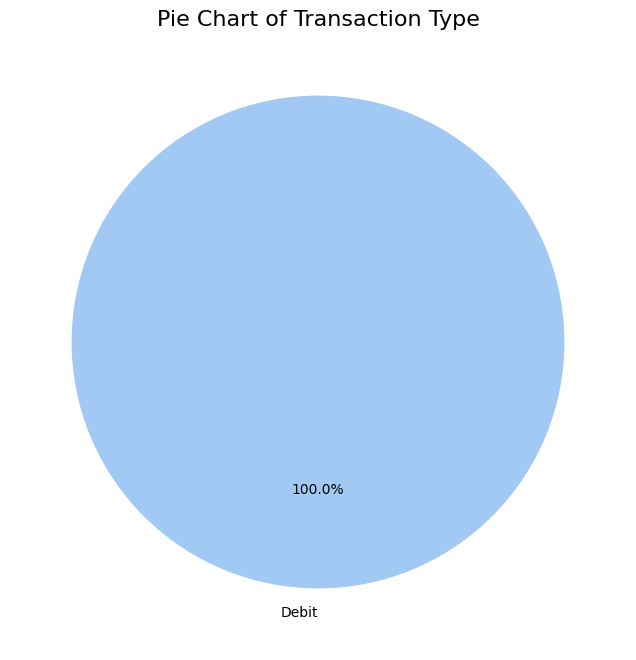

In [5]:
# Pie chart for 'TransactionType'
plt.figure(figsize=(8, 8))
data['TransactionType'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Pie Chart of Transaction Type', fontsize=16)
plt.ylabel('')  # Remove default y-axis label
plt.show()

Data Preprocessing

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1944 entries, 0 to 2510
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            1944 non-null   object 
 1   AccountID                1944 non-null   object 
 2   TransactionAmount        1944 non-null   float64
 3   TransactionDate          1944 non-null   object 
 4   TransactionType          1944 non-null   object 
 5   Location                 1944 non-null   object 
 6   DeviceID                 1944 non-null   object 
 7   IP Address               1944 non-null   object 
 8   MerchantID               1944 non-null   object 
 9   Channel                  1944 non-null   object 
 10  TransactionDuration      1944 non-null   int64  
 11  LoginAttempts            1944 non-null   int64  
 12  AccountBalance           1944 non-null   float64
 13  PreviousTransactionDate  1944 non-null   object 
dtypes: float64(2), int64(2), obje

In [43]:
data.describe()

TransactionAmount  TransactionDuration  LoginAttempts  AccountBalance
count        1944.000000          1944.000000    1944.000000     1944.000000
mean          294.991255           119.716049       1.118827     5074.849805
std           292.527512            70.513970       0.585267     3867.504758
min             0.260000            10.000000       1.000000      101.250000
25%            83.137500            63.000000       1.000000     1482.977500
50%           205.140000           114.000000       1.000000     4710.125000
75%           407.785000           162.000000       1.000000     7630.422500
max          1919.110000           300.000000       5.000000    14977.990000

In [44]:
print("Missing values: \n", data.isnull().sum())

# Fill or drop missing values (example: fill missing numeric columns with median)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Handle categorical data (example: fill missing with mode)
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Convert date columns to datetime format (if applicable)
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])

# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Drop columns with too many missing values (optional)
numeric_data = numeric_data.dropna(axis=1, thresh=len(numeric_data) * 0.5)  # Keep columns with >50% non-NaN values

# Fill remaining missing values with median (optional)
numeric_data = numeric_data.fillna(numeric_data.median())

Missing values: 
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


# Exploratory Data Analysis

## 1. Univariant Analysis

Correlation Matrix:
                     TransactionAmount  TransactionDuration  LoginAttempts  \
TransactionAmount             1.000000             0.011932      -0.014599   
TransactionDuration           0.011932             1.000000       0.033517   
LoginAttempts                -0.014599             0.033517       1.000000   
AccountBalance               -0.028185            -0.003430       0.020831   

                     AccountBalance  
TransactionAmount         -0.028185  
TransactionDuration       -0.003430  
LoginAttempts              0.020831  
AccountBalance             1.000000  


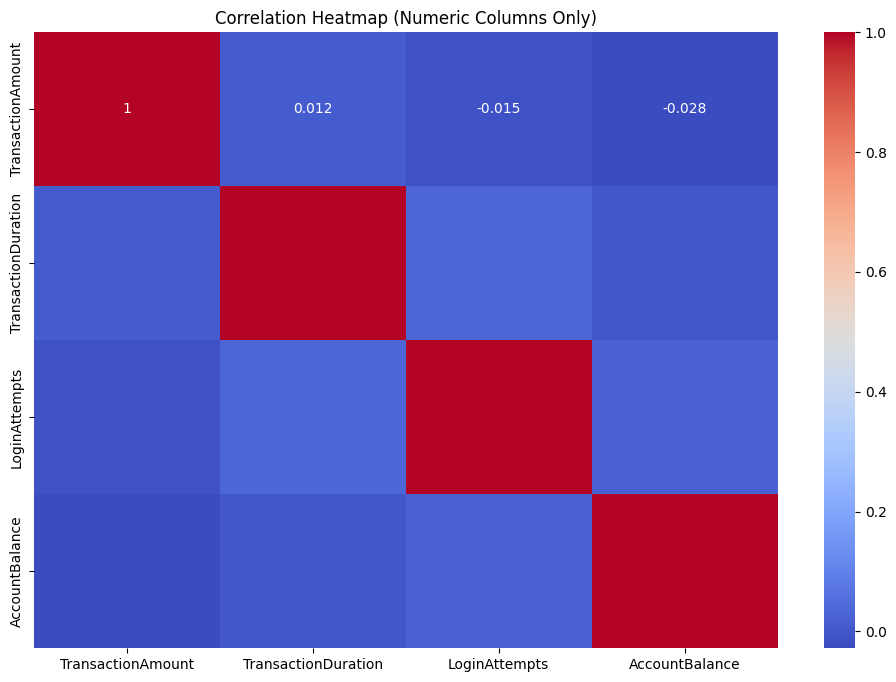

In [50]:
# Compute the correlation matrix for numeric data only
correlation_matrix = numeric_data.corr()

# Verify the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Columns Only)')
plt.show()

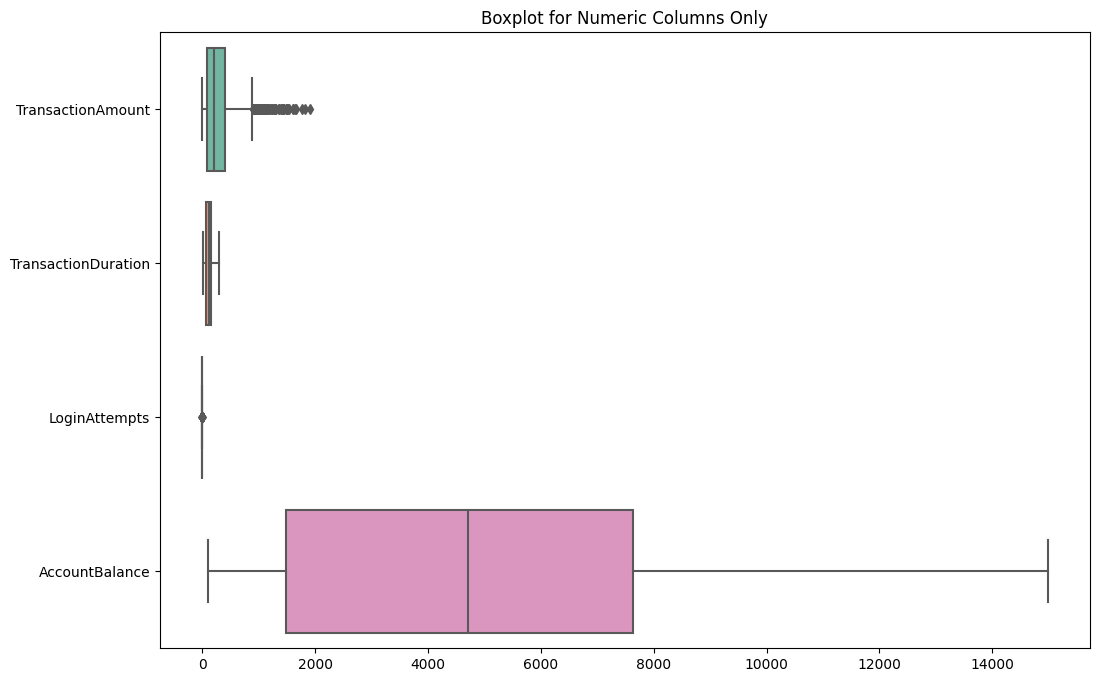

In [51]:
# Additional: Boxplot for numeric columns only
plt.figure(figsize=(12, 8))
sns.boxplot(data=numeric_data, orient="h", palette="Set2")
plt.title('Boxplot for Numeric Columns Only')
plt.show()

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


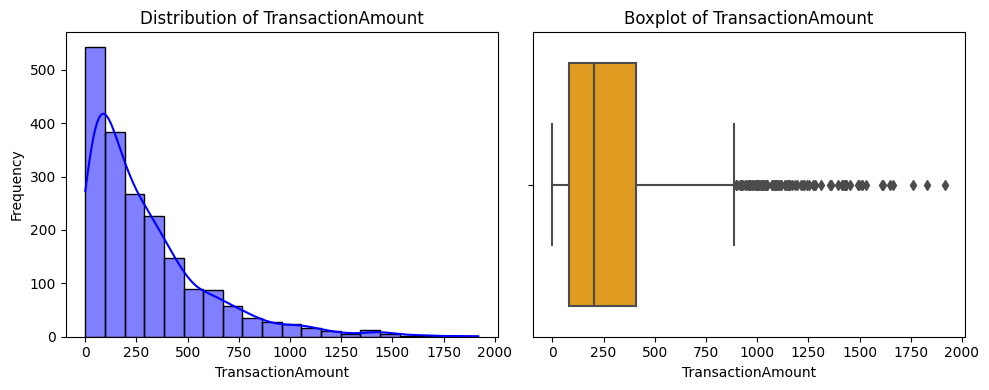

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


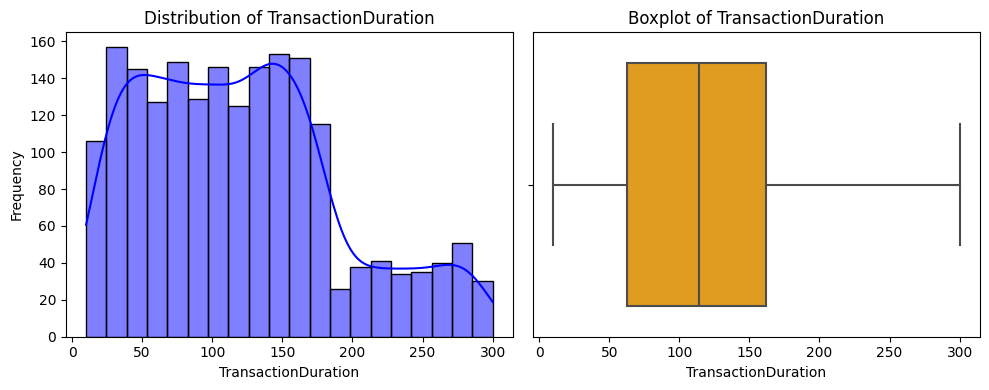

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


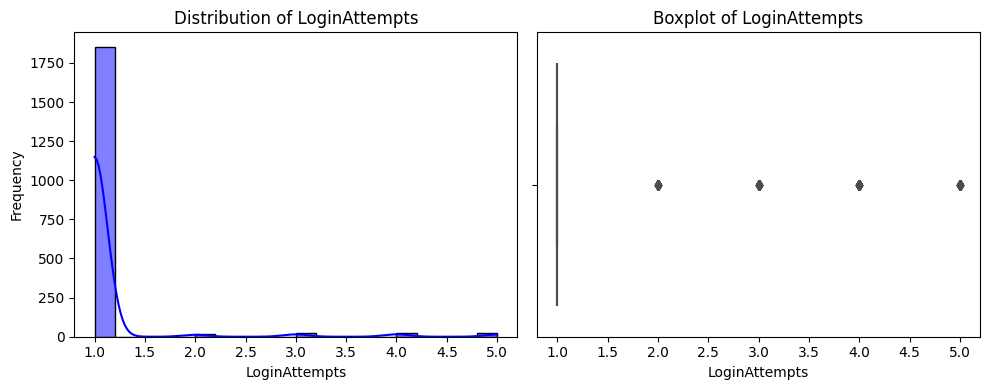

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


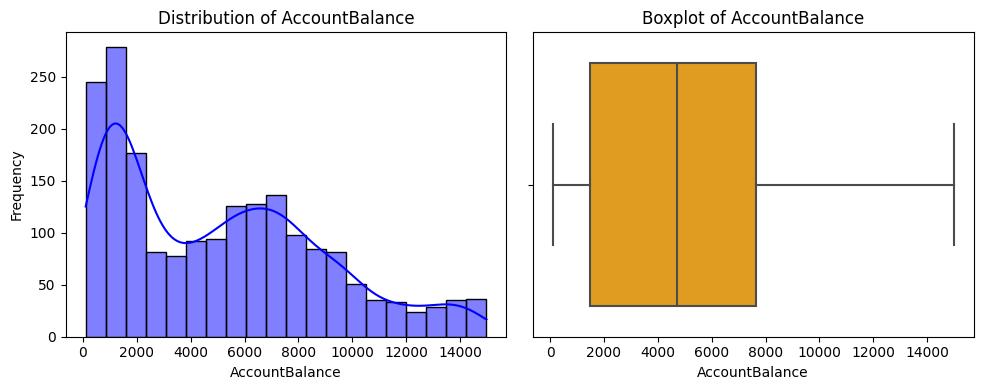

In [53]:
# Step 1: Identify numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Plot univariate graphs
for col in numeric_cols:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, bins=20, color='blue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col], color='orange')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


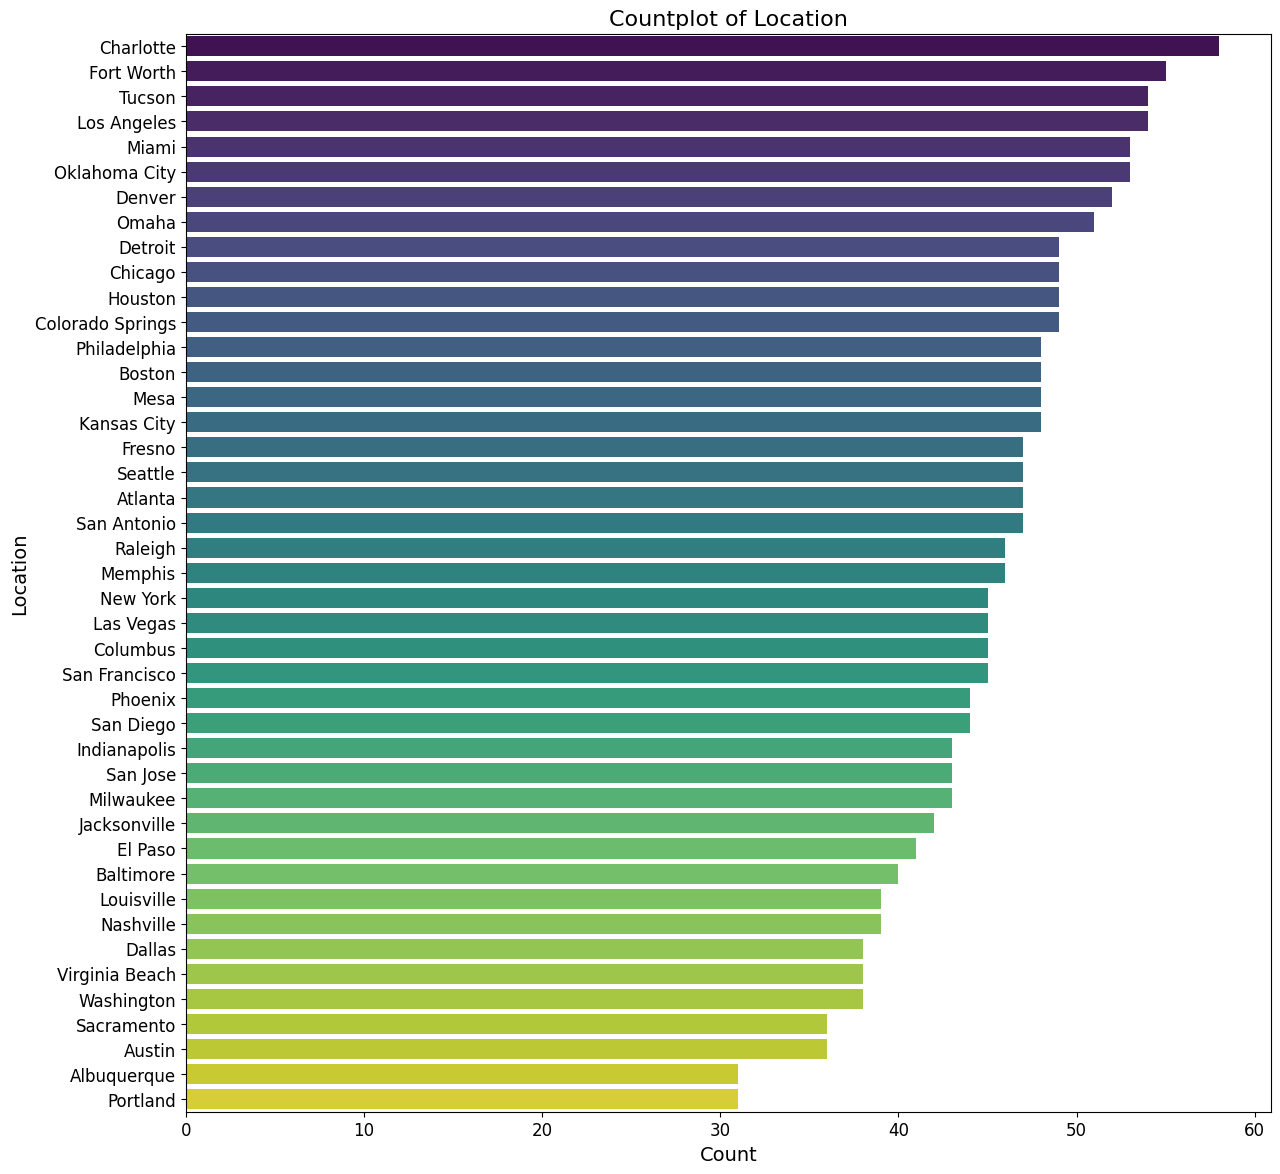

In [55]:
# Countplot for 'Location'
plt.figure(figsize=(14, 14))
sns.countplot(y=data['Location'], order=data['Location'].value_counts().index, palette='viridis')
plt.title('Countplot of Location', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Location', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

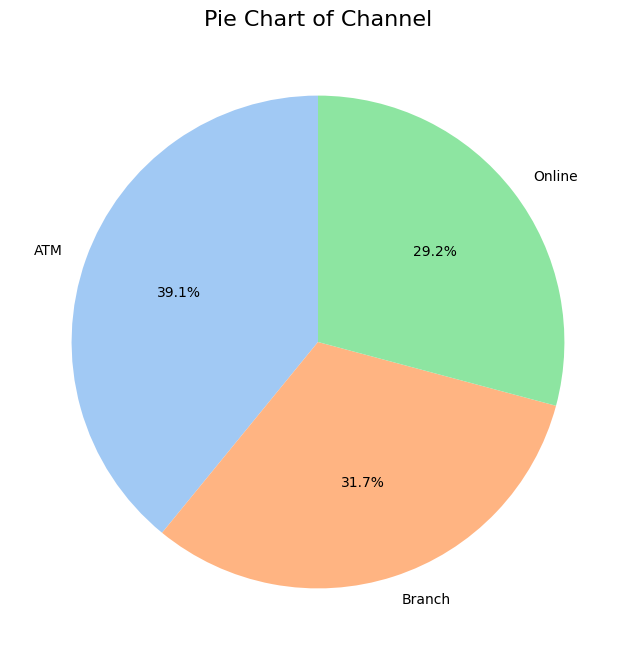

In [58]:
# Pie chart for 'Channel'
plt.figure(figsize=(8, 8))
data['Channel'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Pie Chart of Channel', fontsize=16)
plt.ylabel('')  # Remove default y-axis label
plt.show()


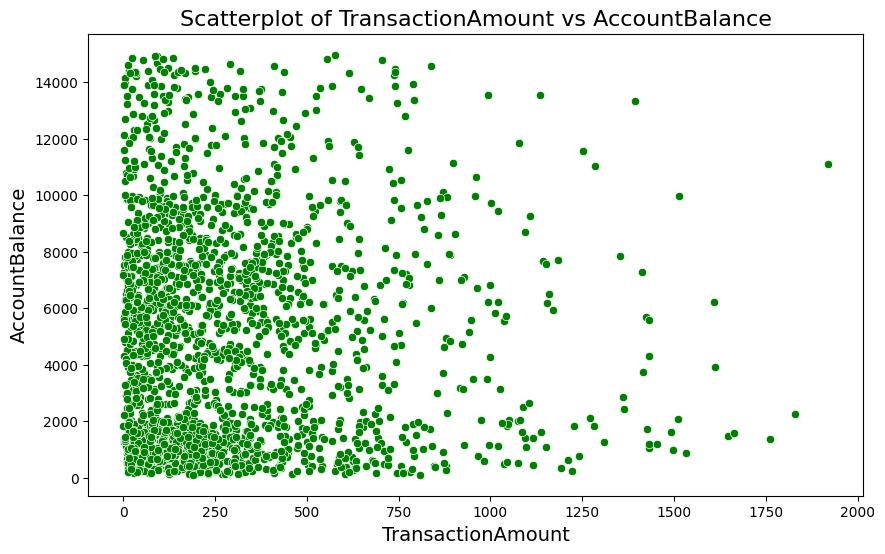

In [64]:
# Scatterplot for any two numeric variables (e.g., 'TransactionAmount' vs 'AccountBalance')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['TransactionAmount'], y=data['AccountBalance'], color='green')
plt.title('Scatterplot of TransactionAmount vs AccountBalance', fontsize=16)
plt.xlabel('TransactionAmount', fontsize=14)
plt.ylabel('AccountBalance', fontsize=14)
plt.show()

## Bivariate Analysis

In [65]:
# Define numeric and categorical columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
categorical_cols = ['TransactionType', 'Location', 'Channel', 'MerchantID']

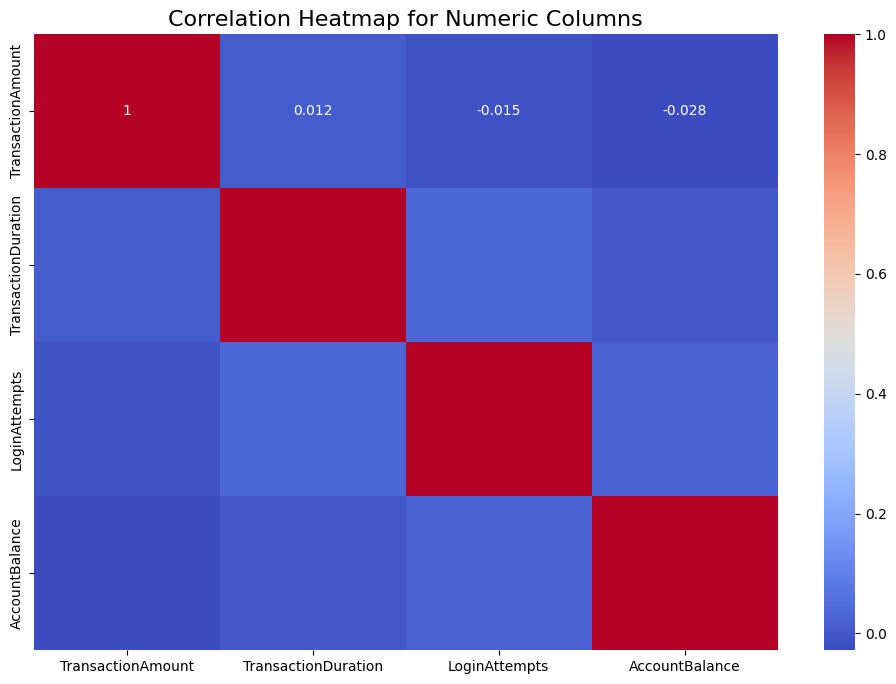

In [66]:
# 1. Correlation Heatmap for Numeric Columns
plt.figure(figsize=(12, 8))
sns.heatmap(debit_transactions[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Numeric Columns', fontsize=16)
plt.show()

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


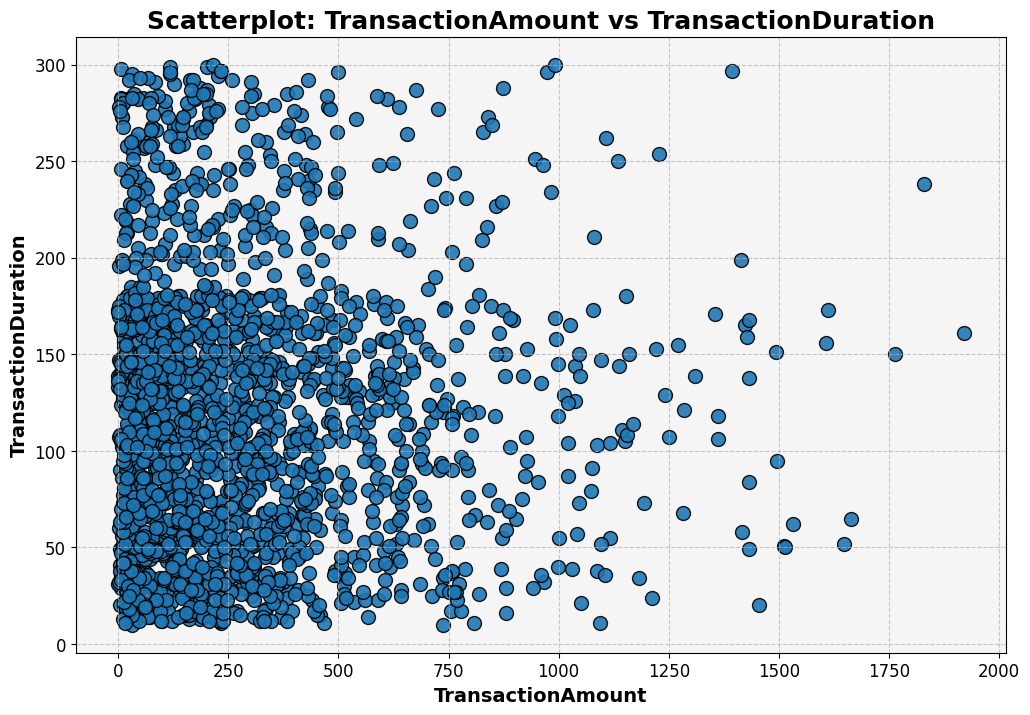

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


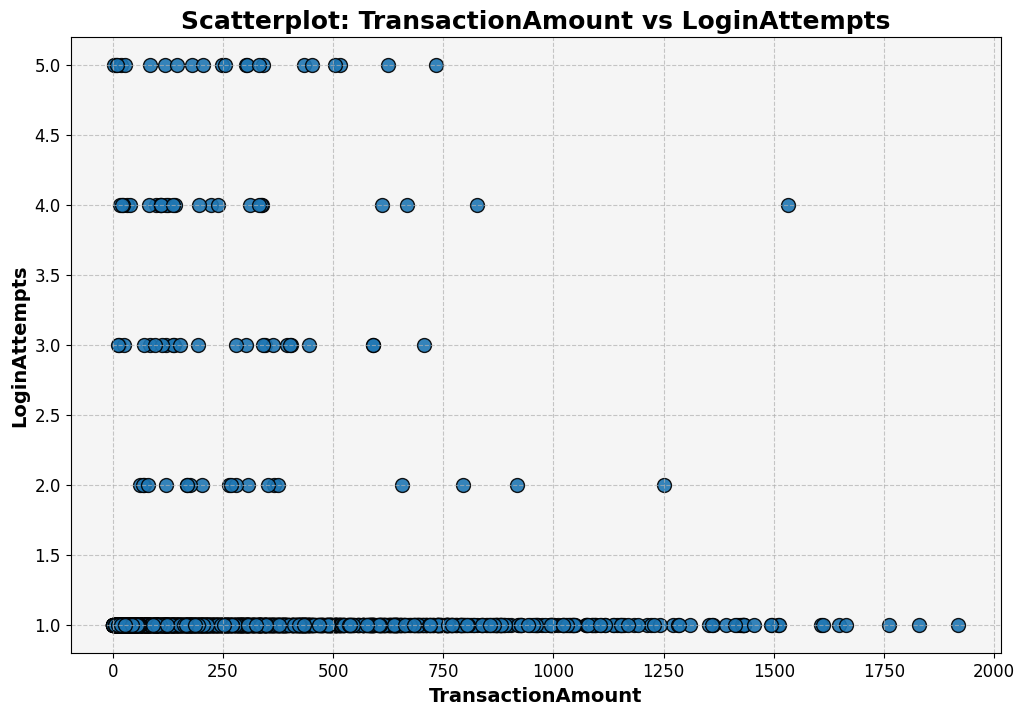

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


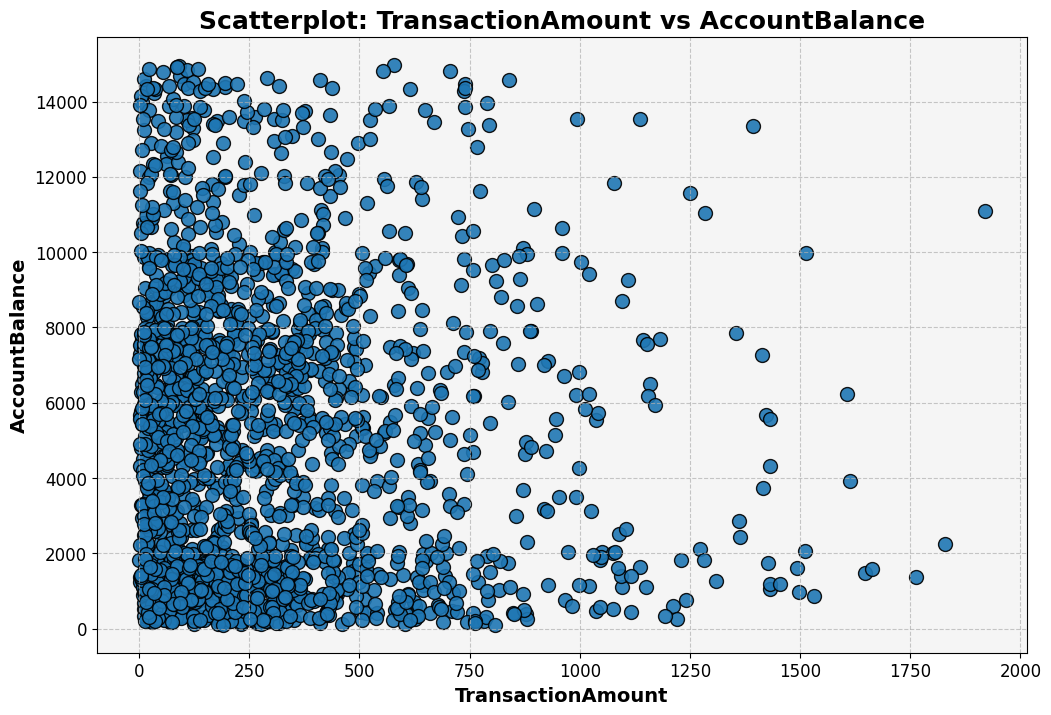

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


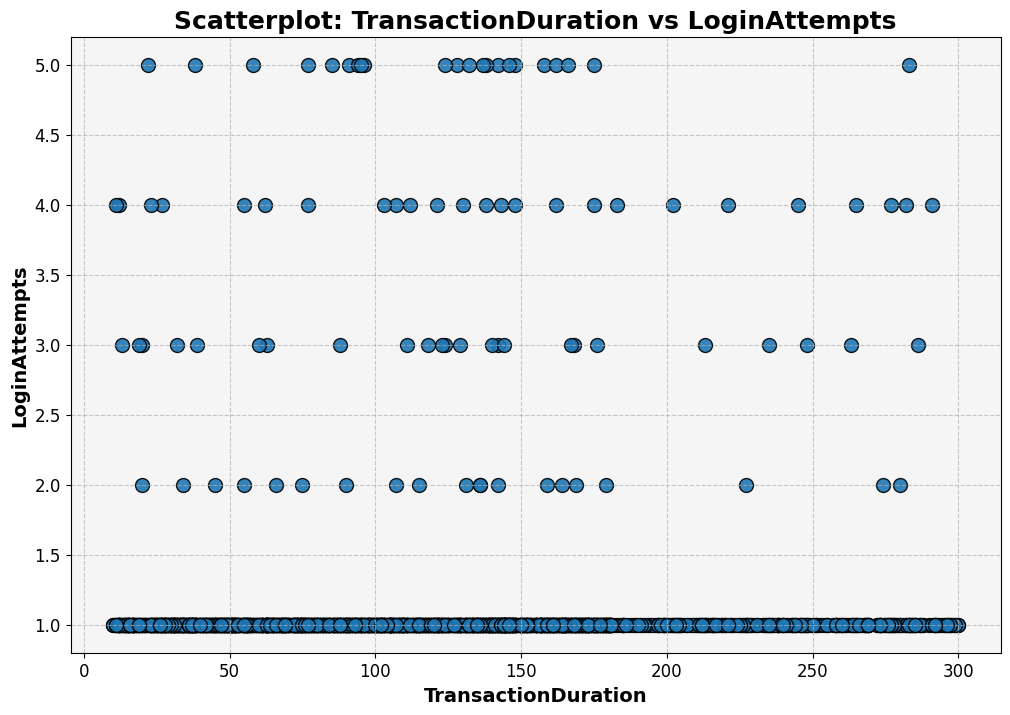

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


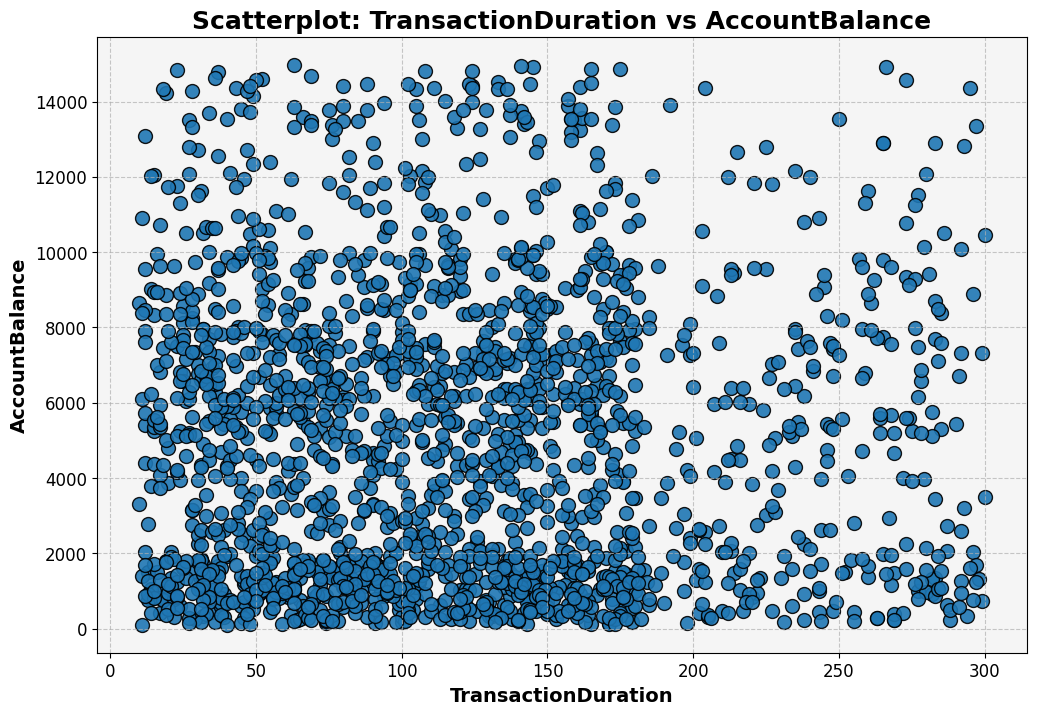

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


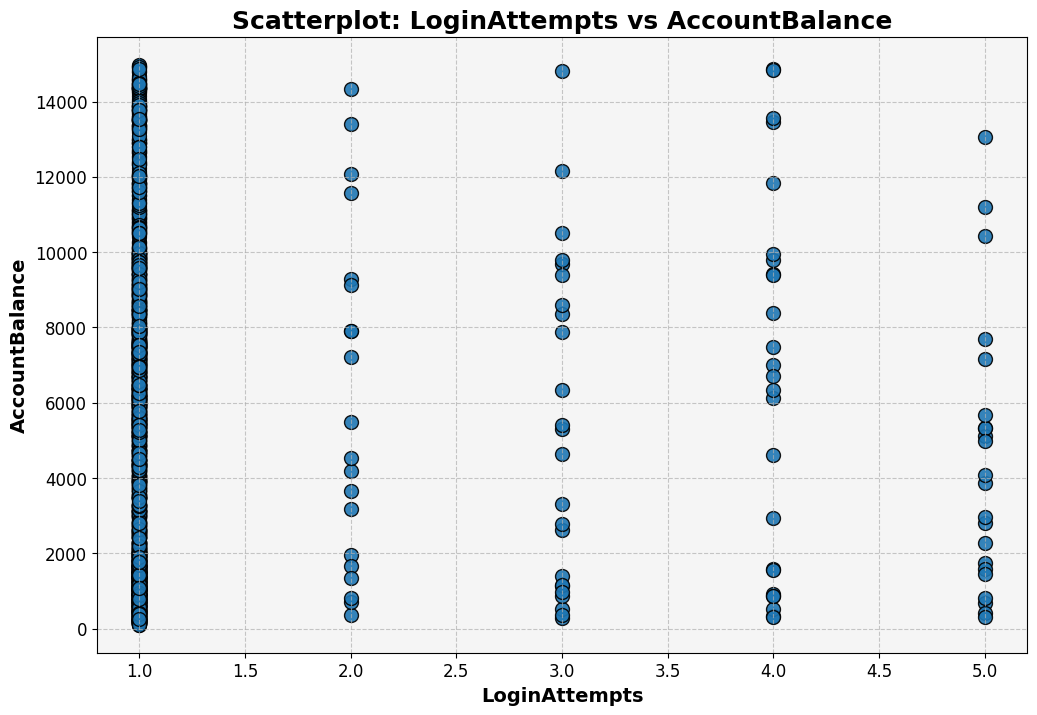

In [71]:
# 2. Scatterplots for Numeric vs Numeric with enhanced design
for i, col1 in enumerate(numeric_cols):
    for col2 in numeric_cols[i+1:]:
        plt.figure(figsize=(12, 8))
        
        # Use a vibrant color palette
        sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2], 
                        alpha=0.9, # Less transparency for vibrant color
                        palette='viridis', # Vibrant color palette
                        s=100, # Increase dot size for better visibility
                        edgecolor='black', # Adding black edge around dots for contrast
                        linewidth=1) # Make edges of the points clearer
        
        # Titles and labels
        plt.title(f'Scatterplot: {col1} vs {col2}', fontsize=18, fontweight='bold')
        plt.xlabel(col1, fontsize=14, fontweight='bold')
        plt.ylabel(col2, fontsize=14, fontweight='bold')
        
        # Enhance gridlines and background
        plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines with low opacity
        plt.gca().set_facecolor('whitesmoke')  # Light background color for clarity

        # Increase font size of ticks for better readability
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # Save the plot with high resolution (DPI)
        plt.savefig(f"scatterplot_{col1}_vs_{col2}.png", dpi=300)  # High DPI for quality
        
        # Show plot
        plt.show()

## MultiVariate Analysis

In [74]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

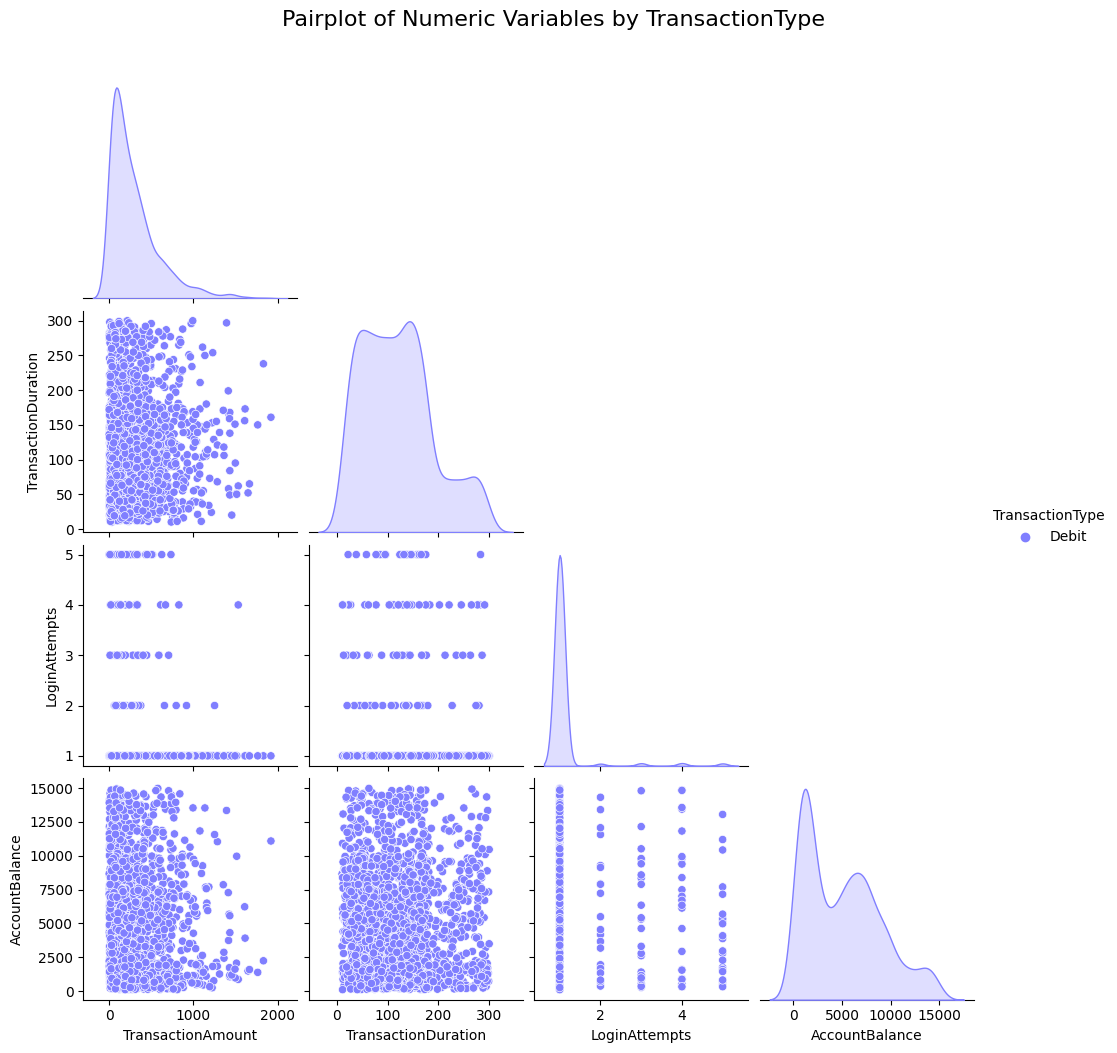

In [114]:
# 1. Multivariate Pairplot (Numeric variables colored by TransactionType)
sns.pairplot(data, vars=numeric_cols, hue='TransactionType', palette='cool', corner=True, diag_kind='kde')
plt.suptitle('Pairplot of Numeric Variables by TransactionType', fontsize=16, y=1.05)
plt.show()

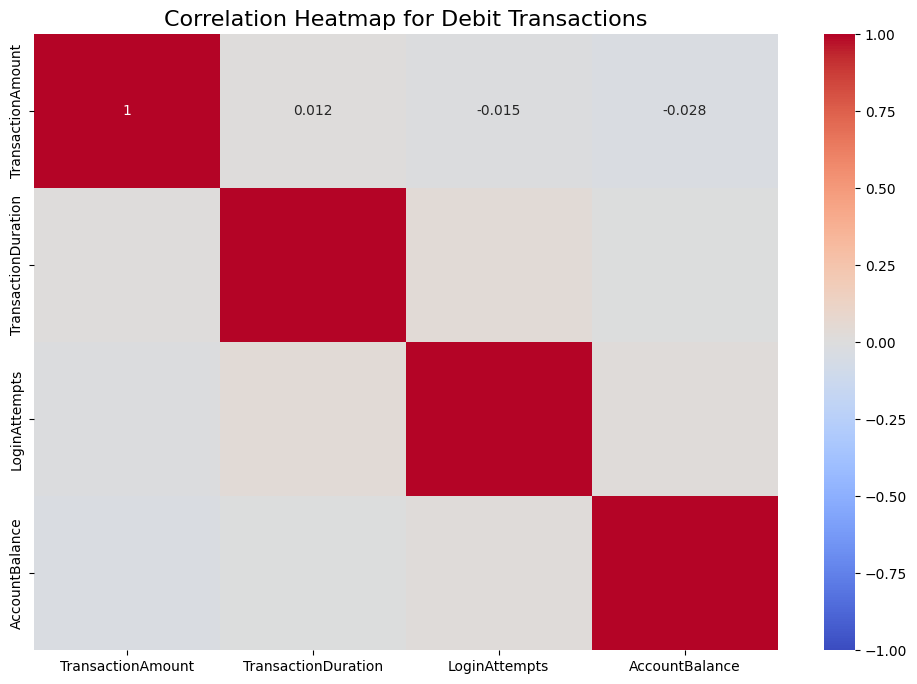

In [79]:
# 2. Heatmap of Numeric Correlations grouped by TransactionType
for trans_type in data['TransactionType'].unique():
    subset = data[data['TransactionType'] == trans_type]
    plt.figure(figsize=(12, 8))
    sns.heatmap(subset[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {trans_type} Transactions', fontsize=16)
    plt.show()

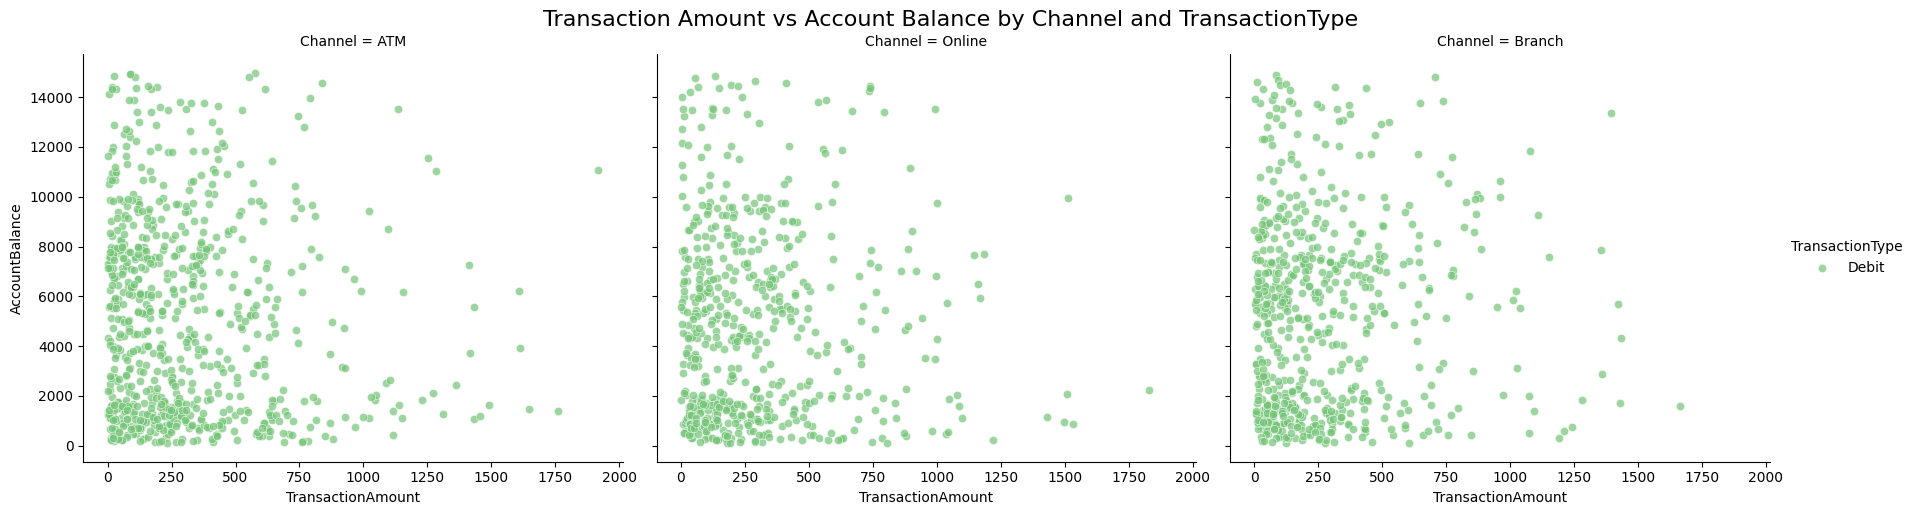

In [112]:
# 3. FacetGrid: Scatterplot of Transaction Amount vs Account Balance by Channel
g = sns.FacetGrid(data, col="Channel", hue="TransactionType", palette="Greens", height=5, aspect=1.2)
g.map(sns.scatterplot, "TransactionAmount", "AccountBalance", alpha=0.7)
g.add_legend()
g.fig.suptitle('Transaction Amount vs Account Balance by Channel and TransactionType', fontsize=16, y=1.02)
plt.show()

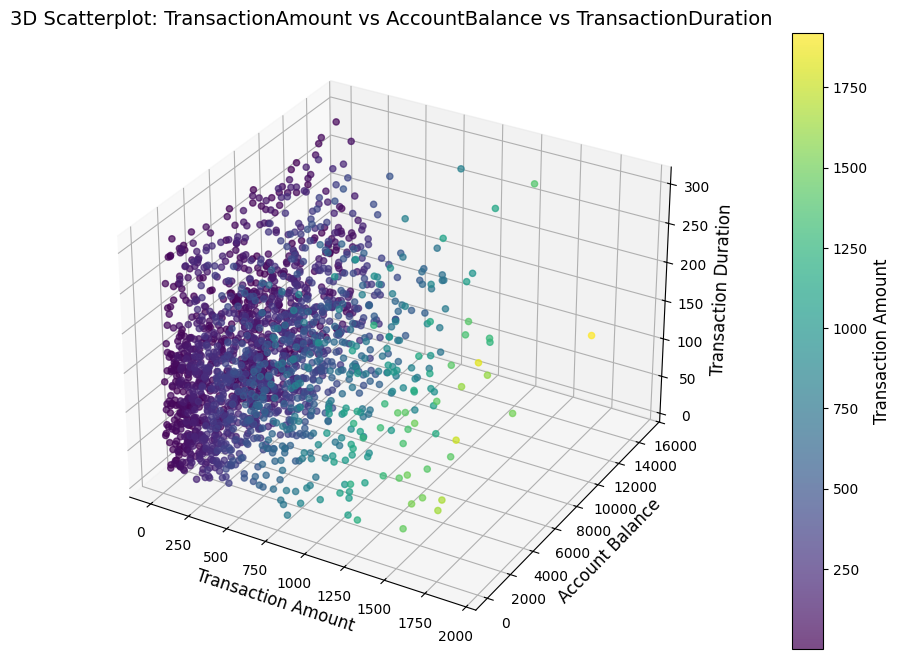

In [111]:
# 4. 3D Scatterplot: Visualize three numeric variables
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    data['TransactionAmount'], 
    data['AccountBalance'], 
    data['TransactionDuration'], 
    c=data['TransactionAmount'], 
    cmap='viridis', 
    alpha=0.7
)
ax.set_xlabel('Transaction Amount', fontsize=12)
ax.set_ylabel('Account Balance', fontsize=12)
ax.set_zlabel('Transaction Duration', fontsize=12)
plt.title('3D Scatterplot: TransactionAmount vs AccountBalance vs TransactionDuration', fontsize=14)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Transaction Amount', fontsize=12)
plt.show()

## Fraud Detection

In [18]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

print("Training data size:", len(train_data))
print("Test data size:", len(test_data))

Training data size: 1399
Test data size: 156


In [19]:
test_data.head()

TransactionID AccountID  TransactionAmount     TransactionDate  \
1324      TX001325   AC00482             686.17 2023-10-03 17:27:25   
397       TX000398   AC00293             131.46 2023-05-15 16:37:12   
472       TX000473   AC00213             423.11 2023-07-25 18:41:02   
178       TX000179   AC00156             237.06 2023-12-18 16:47:17   
55        TX000056   AC00374             316.95 2023-08-04 17:53:40   

     TransactionType   Location DeviceID      IP Address MerchantID Channel  \
1324           Debit     Denver  D000103  199.199.60.222       M030     ATM   
397            Debit  Charlotte  D000287   146.69.70.214       M006  Branch   
472            Debit   Columbus  D000113    64.57.44.102       M055     ATM   
178            Debit    Phoenix  D000455    61.95.76.233       M049  Online   
55             Debit       Mesa  D000013   81.102.230.41       M052  Branch   

      TransactionDuration  LoginAttempts  AccountBalance  \
1324                   96              1         2246.15   
397                   258              1         6642.33   
472                    47              1          412.78   
178                    46              1         1182.77   
55                     83              1         1324.03   

     PreviousTransactionDate  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
1324     2024-11-04 08:07:37               -34353612.0  False               3   
397      2024-11-04 08:11:30               -46539258.0  False               0   
472      2024-11-04 08:10:58               -40397396.0  False               4   
178      2024-11-04 08:07:50               -27789633.0  False               4   
55       2024-11-04 08:09:15               -39536135.0  False               4   

      KMeans_Distance  KMeans_Fraud  
1324         0.846230         False  
397          0.897647         False  
472          1.093060         False  
178          0.647288         False  
55           0.531340         False

#### Use the below line of code to change to the test_data and run the code:

In [ ]:
data = train_data

In [20]:

# Preprocessing: Handle datetime columns
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'],format='%Y-%m-%d %H:%M:%S')
data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'],format='%Y-%m-%d %H:%M:%S')
data['TimeSinceLastTransaction'] = (data['TransactionDate'] - data['PreviousTransactionDate']).dt.total_seconds()

# Identify numeric and categorical columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'TimeSinceLastTransaction']
categorical_cols = ['TransactionType', 'Location', 'Channel']

# Normalize numeric columns
scaler = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), columns=numeric_cols)

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Avoid dummy variable trap
categorical_encoded = pd.DataFrame(encoder.fit_transform(data[categorical_cols]), 
                                   columns=encoder.get_feature_names_out(categorical_cols))

# Combine preprocessed data
processed_data = pd.concat([numeric_scaled, categorical_encoded], axis=1)

# Descriptive Statistics
print("Descriptive Statistics:")
print(data[numeric_cols].describe())

# Initialize Fraud column
data['Fraud'] = False

Descriptive Statistics:
       TransactionAmount  TransactionDuration  LoginAttempts  AccountBalance  \
count        1399.000000          1399.000000    1399.000000     1399.000000   
mean          296.741730           120.323088       1.097212     5023.831165   
std           294.843076            71.211205       0.538091     3861.189846   
min             0.260000            10.000000       1.000000      102.200000   
25%            79.760000            63.000000       1.000000     1484.535000   
50%           204.630000           114.000000       1.000000     4577.090000   
75%           415.690000           163.000000       1.000000     7618.515000   
max          1919.110000           300.000000       5.000000    14977.990000   

       TimeSinceLastTransaction  
count              1.399000e+03  
mean              -4.241659e+07  
std                9.157098e+06  
min               -5.803261e+07  
25%               -5.051225e+07  
50%               -4.230689e+07  
75%              

### Model 1: K-means Clustering
Identifies anomalies based on distance from centroids.

In [21]:
pip install --upgrade scikit-learn threadpoolctl

Note: you may need to restart the kernel to use updated packages.


Threshold: 2.524628865251704
Fraud Summary:
KMeans_Fraud
False    1377
True       22
Name: count, dtype: int64
      TransactionAmount  KMeans_Distance  KMeans_Fraud
2297             111.41         1.060901         False
1511             288.43         0.736206         False
2267            1360.67         1.731135         False
74              1212.51         1.968959         False
1556             170.97         1.310280         False


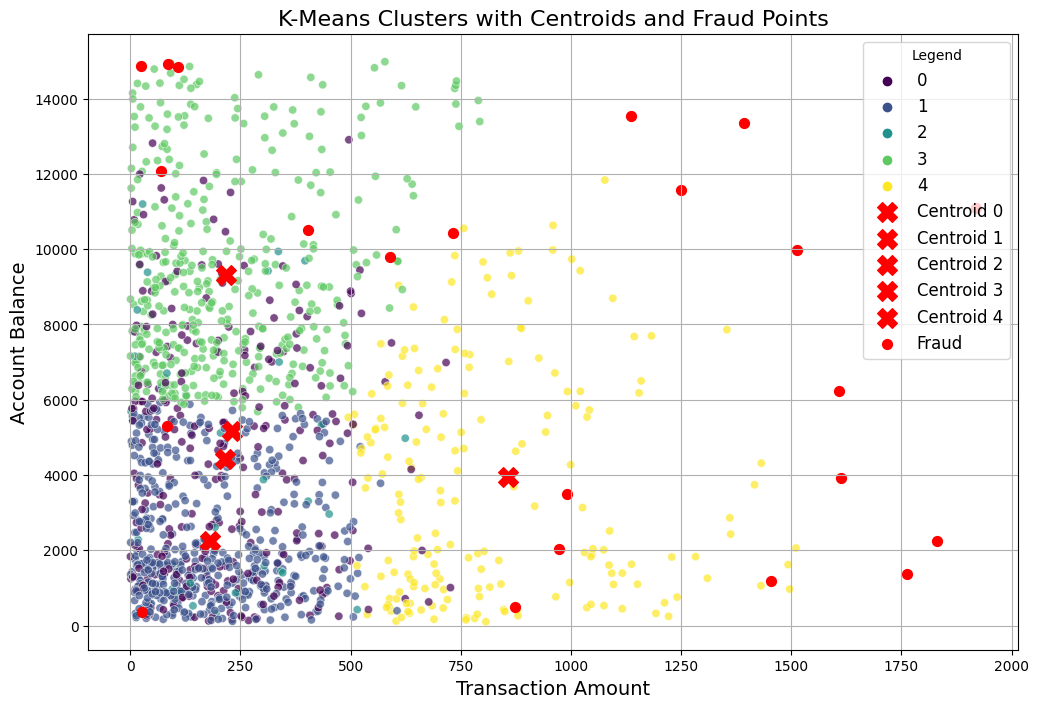

In [22]:
# Identify numeric columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

# Assuming 'data' is already defined and contains the necessary columns
# Standardize numeric columns for clustering
scaler = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), columns=numeric_cols)

# Perform K-Means clustering
n_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(numeric_scaled)
data['KMeans_Cluster'] = kmeans_labels

# Calculate distances from centroids
centroids = kmeans.cluster_centers_
distances = np.linalg.norm(numeric_scaled.values - centroids[kmeans_labels], axis=1)
data['KMeans_Distance'] = distances

# Set threshold: Mean + 3 * Standard Deviation
threshold = distances.mean() + 3 * distances.std()
data['KMeans_Fraud'] = distances > threshold

# Summary of flagged anomalies
fraud_summary = data['KMeans_Fraud'].value_counts()
print(f"Threshold: {threshold}")
print(f"Fraud Summary:\n{fraud_summary}")
print(data[['TransactionAmount', 'KMeans_Distance', 'KMeans_Fraud']].head())

# Calculate centroids and scale them back to the original feature space
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Scatterplot for two features with clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['KMeans_Cluster'],
    palette='viridis',
    alpha=0.7,
    legend='full'
)

# Overlay centroids on the scatterplot
for i, centroid in enumerate(centroids_original):
    plt.scatter(
        centroid[numeric_cols.index('TransactionAmount')],
        centroid[numeric_cols.index('AccountBalance')],
        color='red',
        marker='X',
        s=200,
        label=f'Centroid {i}'
    )

# Highlight fraud points
fraud_points = data[data['KMeans_Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['AccountBalance'],
    color='red',
    marker='o',
    s=50,
    label='Fraud'
)

plt.title('K-Means Clusters with Centroids and Fraud Points', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Legend', fontsize=12)
plt.grid(True)
plt.show()

In [23]:
# Save fraud transactions to a separate CSV file
fraud_output_path = '/Users/raghav/Downloads/kmeans_fraud_transactions.csv'
fraud_points.to_csv(fraud_output_path, index=False)

# Print summary of fraud points
total_fraud_points = data['Fraud'].sum()
print(f"Total Fraudulent Transactions Detected (Using K Means clustering): {total_fraud_points}")
print(f"Fraudulent transactions saved to: {fraud_output_path}")

# Display fraud transactions
print("Fraudulent Transactions Detected:")
fraud_points

Total Fraudulent Transactions Detected (Using K Means clustering): 0
Fraudulent transactions saved to: /Users/raghav/Downloads/kmeans_fraud_transactions.csv
Fraudulent Transactions Detected:


TransactionID AccountID  TransactionAmount     TransactionDate  \
754       TX000755   AC00153              84.34 2023-06-08 16:27:56   
693       TX000694   AC00011             733.29 2023-03-15 18:42:16   
2445      TX002446   AC00439             403.01 2023-09-04 17:32:35   
1788      TX001789   AC00338            1612.37 2023-07-24 17:46:13   
1634      TX001635   AC00358            1762.28 2023-10-06 16:05:34   
1618      TX001619   AC00305             108.75 2023-10-17 16:09:20   
1796      TX001797   AC00146            1135.80 2023-09-06 16:03:15   
653       TX000654   AC00423            1919.11 2023-06-27 17:48:25   
1726      TX001727   AC00120              85.73 2023-03-01 16:09:58   
1531      TX001532   AC00432              26.07 2023-03-16 17:00:29   
2149      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
146       TX000147   AC00385             973.39 2023-08-30 17:23:20   
755       TX000756   AC00460            1607.55 2023-09-07 16:27:03   
1447      TX001448   AC00080             991.82 2023-12-04 16:16:19   
1534      TX001535   AC00407             872.72 2023-04-24 16:47:17   
340       TX000341   AC00107            1830.00 2023-03-01 16:31:58   
2330      TX002331   AC00415              69.38 2023-01-11 16:09:36   
924       TX000925   AC00237             590.01 2023-02-06 16:42:16   
375       TX000376   AC00316            1392.54 2023-11-20 16:51:14   
1984      TX001985   AC00303            1512.99 2023-08-08 17:15:50   
2272      TX002273   AC00268            1454.52 2023-09-22 16:13:06   
850       TX000851   AC00124              23.40 2023-02-08 18:27:49   

     TransactionType        Location DeviceID       IP Address MerchantID  \
754            Debit         Memphis  D000493   200.136.146.93       M039   
693            Debit  Virginia Beach  D000618    16.51.235.240       M032   
2445           Debit      Washington  D000677    223.32.70.156       M029   
1788           Debit     Los Angeles  D000025   16.128.130.153       M078   
1634           Debit         Memphis  D000008    26.105.49.129       M066   
1618           Debit         Houston  D000081  119.163.214.161       M097   
1796           Debit       San Diego  D000485     16.131.3.140       M004   
653            Debit        Portland  D000191  207.157.126.125       M033   
1726           Debit  Virginia Beach  D000072  134.222.122.238       M100   
1531           Debit       Baltimore  D000552    194.174.252.1       M061   
2149           Debit        Columbus  D000282      35.67.21.23       M054   
146            Debit      Sacramento  D000292   202.194.199.70       M026   
755            Debit         Phoenix  D000070    94.37.250.128       M031   
1447           Debit       Milwaukee  D000496    62.152.134.92       M042   
1534           Debit      Washington  D000559   216.79.134.201       M033   
340            Debit     San Antonio  D000436    62.27.235.199       M082   
2330           Debit         Detroit  D000191   22.196.202.183       M042   
924            Debit        San Jose  D000248   197.162.55.147       M044   
375            Debit         El Paso  D000113    63.67.150.226       M013   
1984           Debit    Philadelphia  D000032  195.164.171.146       M071   
2272           Debit           Miami  D000598    34.169.232.37       M088   
850            Debit         El Paso  D000079     74.58.165.67       M027   

     Channel  TransactionDuration  LoginAttempts  AccountBalance  \
754   Online                  248              3         5313.97   
693      ATM                   94              5        10427.00   
2445  Online                  286              3        10513.52   
1788     ATM                  173              1         3910.59   
1634     ATM                  150              1         1380.34   
1618     ATM                   23              4        14829.85   
1796     ATM                  250              1        13534.30   
653      ATM                  161              1       

There are 5 clusters based on feature similarity. Features are ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

**Fraud Detection Example:**
If a transaction has an unusually high TransactionAmount combined with a short TransactionDuration and a high number of LoginAttempts, it might be flagged as fraud because it deviates significantly from the typical transactions in its cluster.

### Model 2: Z-Score Analysis
Flags extreme outliers in selected numerical features.

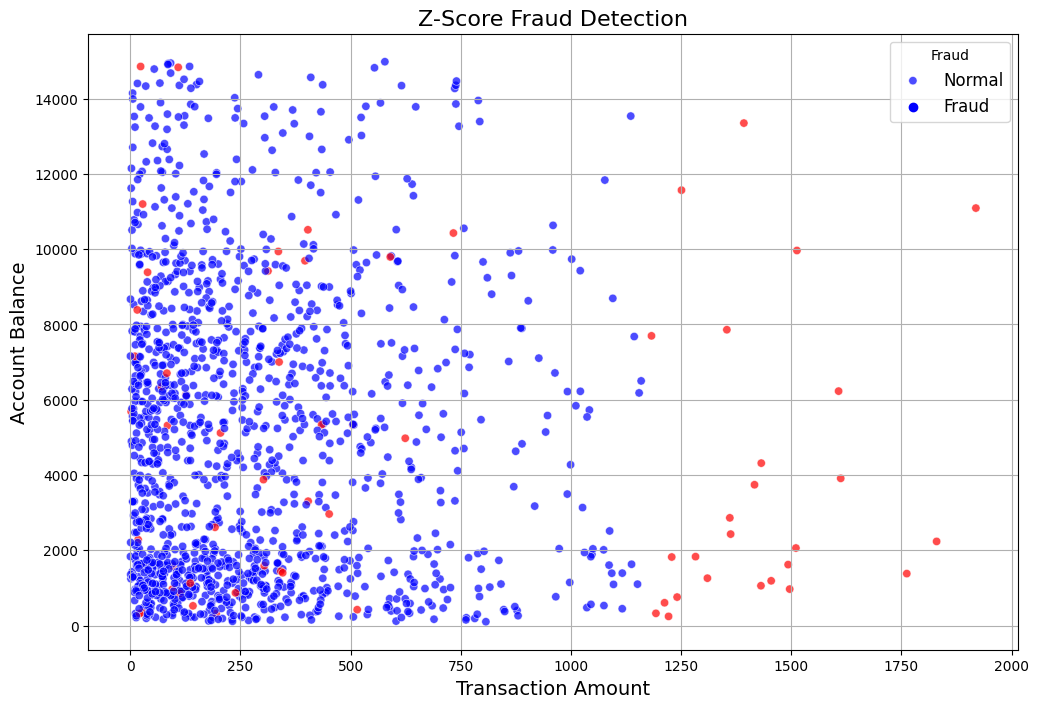

In [24]:
from scipy.stats import zscore


# Define numeric columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

# Calculate Z-Scores
z_scores = np.abs(zscore(data[numeric_cols]))
data['ZScore_Fraud'] = (z_scores > 3).any(axis=1)  # Flag transactions where any feature exceeds |z| > 3

# Extract fraudulent transactions
zscore_fraud_points = data[data['ZScore_Fraud']]

# Summary of results
total_zscore_fraud_points = data['ZScore_Fraud'].sum()
zscore_fraud_points_summary = zscore_fraud_points[numeric_cols + ['ZScore_Fraud']]

# Adding True values to Fraud column
data['Fraud'] |= data['ZScore_Fraud']

# Scatterplot for Z-Score fraud detection
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['ZScore_Fraud'],
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('Z-Score Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()

In [25]:
# Save fraudulent transactions detected by Z-Score analysis
zscore_fraud_output_path = '/Users/raghav/Downloads/zscore_fraud_transactions.csv'
zscore_fraud_points.to_csv(zscore_fraud_output_path, index=False)

# Summary
print(f"Total Fraudulent Transactions Detected by Z-Score Analysis: {total_zscore_fraud_points}")
print(f"Fraudulent transactions saved to: {zscore_fraud_output_path}")
zscore_fraud_points

Total Fraudulent Transactions Detected by Z-Score Analysis: 67
Fraudulent transactions saved to: /Users/raghav/Downloads/zscore_fraud_transactions.csv


TransactionID AccountID  TransactionAmount     TransactionDate  \
2267      TX002268   AC00416            1360.67 2023-04-19 16:38:41   
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   
486       TX000487   AC00148            1416.69 2023-01-16 17:00:11   
754       TX000755   AC00153              84.34 2023-06-08 16:27:56   
400       TX000401   AC00145             194.85 2023-09-12 16:50:21   
...            ...       ...                ...                 ...   
1363      TX001364   AC00089             204.70 2023-09-21 16:08:00   
837       TX000838   AC00169              39.21 2023-05-10 16:15:31   
1082      TX001083   AC00200             136.05 2023-01-23 16:19:25   
2262      TX002263   AC00279              15.81 2023-03-02 18:36:55   
916       TX000917   AC00272             337.73 2023-05-23 17:12:39   

     TransactionType       Location DeviceID       IP Address MerchantID  \
2267           Debit        Raleigh  D000017   164.75.163.220       M092   
74             Debit   Indianapolis  D000231     193.83.0.183       M036   
486            Debit      Nashville  D000418   219.98.242.240       M015   
754            Debit        Memphis  D000493   200.136.146.93       M039   
400            Debit   Jacksonville  D000601  148.234.210.167       M096   
...              ...            ...      ...              ...        ...   
1363           Debit  Oklahoma City  D000359   141.201.46.191       M032   
837            Debit          Miami  D000059   105.87.212.115       M093   
1082           Debit        Atlanta  D000362    82.115.199.37       M068   
2262           Debit  Oklahoma City  D000606     96.24.89.146       M018   
916            Debit    San Antonio  D000480  219.193.239.152       M065   

     Channel  TransactionDuration  LoginAttempts  AccountBalance  \
2267  Branch                  118              1         2861.65   
74    Branch                   24              1          605.95   
486      ATM                   58              1         3740.73   
754   Online                  248              3         5313.97   
400   Online                  130              4          319.84   
...      ...                  ...            ...             ...   
1363  Branch                   95              5         5117.03   
837      ATM                  245              4         9385.57   
1082  Online                   63              3         1127.54   
2262  Branch                   11              4         8384.85   
916   Online                  107              4         7001.20   

     PreviousTransactionDate  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
2267     2024-11-04 08:06:27               -48785266.0  False               4   
74       2024-11-04 08:06:51               -34270222.0  False               4   
486      2024-11-04 08:11:35               -56819484.0  False               4   
754      2024-11-04 08:09:31               -44466095.0  False               2   
400      2024-11-04 08:08:01               -36170260.0  False               2   
...                      ...                       ...    ...             ...   
1363     2024-11-04 08:10:26               -35395346.0  False               2   
837      2024-11-04 08:11:52               -46972581.0  False               2   
1082     2024-11-04 08:12:00               -56217155.0  False               2   
2262     2024-11-04 08:12:06               -52925711.0  False               2   
916      2024-11-04 08:07:28               -45845689.0  False               2   

      KMeans_Distance  KMeans_Fraud  ZScore_Fraud  
2267         1.731135         False          True  
74           1.968959         False          True  
486          2.067331         False          True  
754          2.621315          True          True  
400          1.265128         False          True  
...               ...           ...           ...  
1363         1.831646         False          True  
837          2.075054         Fal

Flag transactions where any feature exceeds the z-score of 3 standard deviations and updates the Fraud column in data

**Example:**

If a transaction has a TransactionAmount with a Z-Score of 4 (i.e., 4 standard deviations above the mean), it will be flagged as fraud because it significantly deviates from the typical transaction amounts.

### Model 3: Isolation Forest
Highlights anomalous transactions using tree-based partitioning

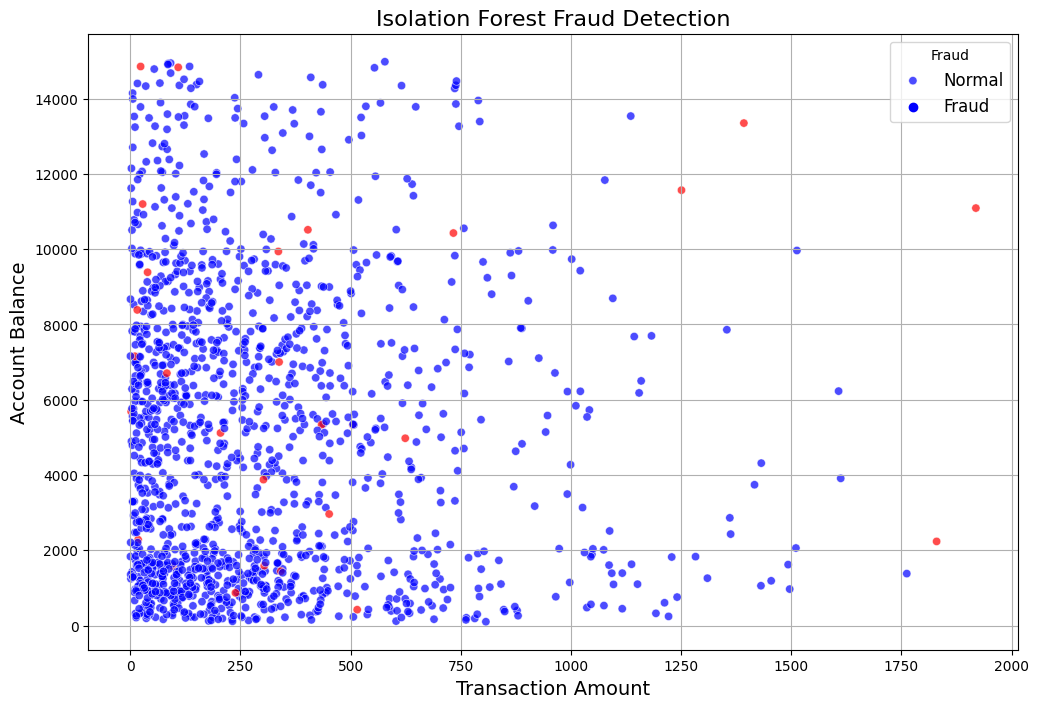

In [26]:
from sklearn.ensemble import IsolationForest
warnings.filterwarnings("ignore", category=FutureWarning)

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)  # 2% expected anomalies
iso_forest.fit(numeric_scaled)  # Fit on the scaled numeric data

# Predict anomalies
data['IsoForest_Score'] = iso_forest.decision_function(numeric_scaled)
data['IsoForest_Fraud'] = iso_forest.predict(numeric_scaled) == -1  # Mark anomalies (-1) as fraud

# Extract fraudulent transactions
iso_fraud_points = data[data['IsoForest_Fraud']]

# Summary of Isolation Forest results
total_iso_fraud_points = data['IsoForest_Fraud'].sum()
iso_fraud_points_summary = iso_fraud_points[['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'IsoForest_Fraud']]

# Adding True values to Fraud column
data['Fraud'] |= data['IsoForest_Fraud']

# Scatterplot to visualize fraud points
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['IsoForest_Fraud'],
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('Isolation Forest Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()

In [27]:
# Outputs
total_iso_fraud_points, iso_fraud_points_summary.head(), iso_fraud_points_summary.shape

# Save fraudulent transactions detected by Isolation Forest
fraud_output_path = '/Users/raghav/Downloads/iso_forest_fraud_transactions.csv'
iso_fraud_points.to_csv(fraud_output_path, index=False)

# Confirm the save location and number of frauds
print(f"Total Fraudulent Transactions Detected (using isolation forest): {total_iso_fraud_points}")
print(f"Fraudulent transactions saved to: {fraud_output_path}\n")
print("Final List of Fraudulent transactions:\n")
iso_fraud_points

Total Fraudulent Transactions Detected (using isolation forest): 28
Fraudulent transactions saved to: /Users/raghav/Downloads/iso_forest_fraud_transactions.csv

Final List of Fraudulent transactions:



TransactionID AccountID  TransactionAmount     TransactionDate  \
693       TX000694   AC00011             733.29 2023-03-15 18:42:16   
2445      TX002446   AC00439             403.01 2023-09-04 17:32:35   
491       TX000492   AC00318             505.19 2023-03-14 16:25:04   
1618      TX001619   AC00305             108.75 2023-10-17 16:09:20   
1774      TX001775   AC00358              17.79 2023-02-22 17:01:35   
547       TX000548   AC00456              97.09 2023-04-10 18:26:56   
1731      TX001732   AC00333               1.93 2023-10-19 18:06:08   
653       TX000654   AC00423            1919.11 2023-06-27 17:48:25   
1121      TX001122   AC00426             303.97 2023-02-02 16:55:25   
147       TX000148   AC00161             514.95 2023-04-13 18:37:48   
1884      TX001885   AC00071             451.31 2023-12-04 16:57:39   
1057      TX001058   AC00191              83.07 2023-01-06 16:13:53   
2149      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
2006      TX002007   AC00227              28.04 2023-02-15 16:37:09   
2159      TX002160   AC00216             624.00 2023-02-16 17:34:34   
1136      TX001137   AC00032             341.67 2023-03-06 16:45:24   
1584      TX001585   AC00358             434.17 2023-01-05 16:40:09   
2288      TX002289   AC00149             336.01 2023-11-09 18:45:10   
2161      TX002162   AC00139              10.15 2023-02-23 16:51:34   
340       TX000341   AC00107            1830.00 2023-03-01 16:31:58   
463       TX000464   AC00417             302.16 2023-10-18 17:47:52   
1733      TX001734   AC00108             238.54 2023-04-07 16:04:01   
375       TX000376   AC00316            1392.54 2023-11-20 16:51:14   
850       TX000851   AC00124              23.40 2023-02-08 18:27:49   
1363      TX001364   AC00089             204.70 2023-09-21 16:08:00   
837       TX000838   AC00169              39.21 2023-05-10 16:15:31   
2262      TX002263   AC00279              15.81 2023-03-02 18:36:55   
916       TX000917   AC00272             337.73 2023-05-23 17:12:39   

     TransactionType          Location DeviceID       IP Address MerchantID  \
693            Debit    Virginia Beach  D000618    16.51.235.240       M032   
2445           Debit        Washington  D000677    223.32.70.156       M029   
491            Debit       Kansas City  D000660    60.89.202.192       M023   
1618           Debit           Houston  D000081  119.163.214.161       M097   
1774           Debit      Jacksonville  D000409   203.245.215.62       M091   
547            Debit        Fort Worth  D000164    221.206.44.63       M052   
1731           Debit           Chicago  D000297    162.58.247.55       M030   
653            Debit          Portland  D000191  207.157.126.125       M033   
1121           Debit        Fort Worth  D000215     7.146.35.122       M056   
147            Debit          New York  D000109     23.92.205.75       M056   
1884           Debit        Fort Worth  D000020   68.254.244.208       M046   
1057           Debit             Miami  D000182   138.210.196.19       M026   
2149           Debit          Columbus  D000282      35.67.21.23       M054   
2006           Debit       Los Angeles  D000101   114.223.129.47       M008   
2159           Debit           Houston  D000207  113.137.153.101       M097   
1136           Debit             Omaha  D000160    140.94.123.72       M037   
1584           Debit           Atlanta  D000238   161.161.26.115       M010   
2288           Debit  Colorado Springs  D000216   16.250.113.156       M043   
2161           Debit            Austin  D000531   55.139.104.163       M004   
340            Debit       San Antonio  D000436    62.27.235.199       M082   
463            Debit       Kansas City  D000123    84.237.126.96       M014   
1733           Debit      Indianapolis  D000428    83.182.211.68       M006   
375            Debit           El Paso  D000113    63.67.150.226       M013   
850            Debit           El Paso  D000079  

**Example:**

If a transaction has unusual values for TransactionAmount and AccountBalance, it will be isolated quickly by the random splits, resulting in a short path length and a high anomaly score. This transaction will be flagged as fraud.

### Logistic Regression
Classifies transactions as fraud or non-fraud using supervised learning.

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       397
        True       1.00      0.78      0.88        23

    accuracy                           0.99       420
   macro avg       0.99      0.89      0.94       420
weighted avg       0.99      0.99      0.99       420



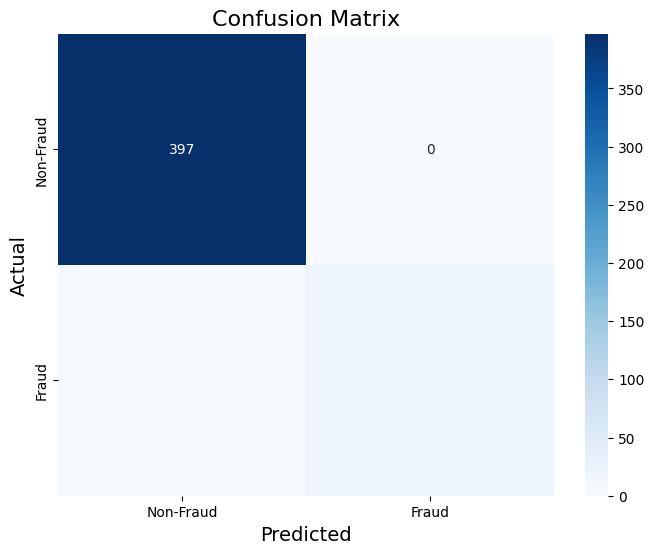

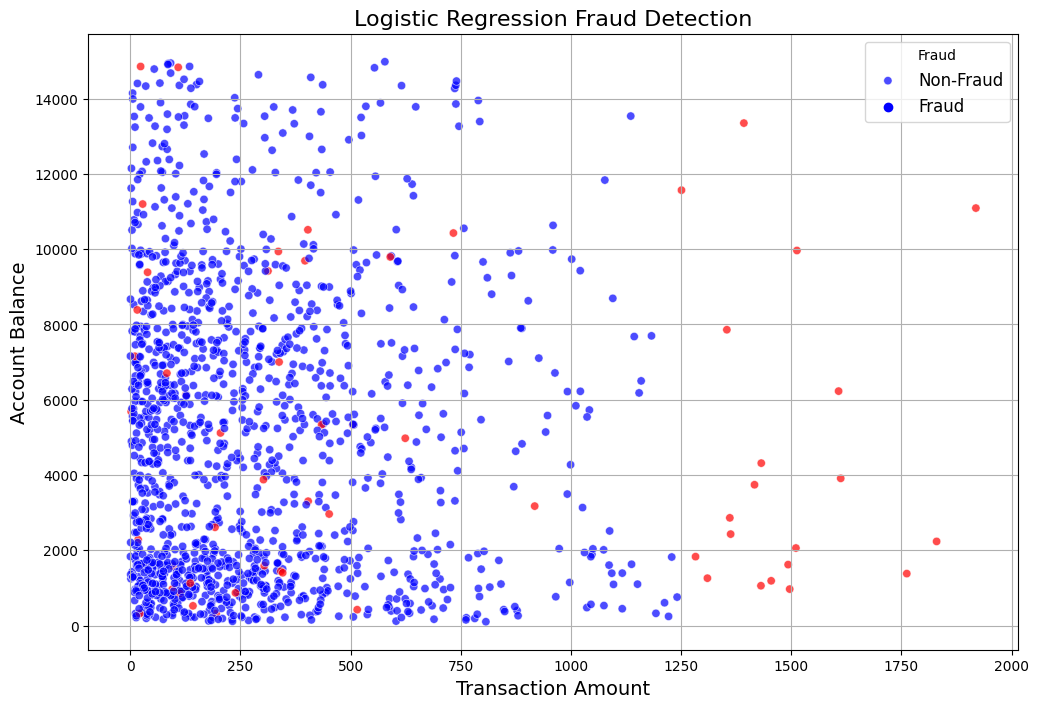

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define relevant columns for logistic regression
features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
target = 'Fraud'

# Prepare the dataset
X = data[features]
y = data[target]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict fraud on the test set
y_pred = log_reg.predict(X_test)


# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# Add predictions to the dataset
data['LogReg_Fraud'] = log_reg.predict(X_scaled)
data['Fraud'] |= data['LogReg_Fraud']

# Visualize fraud vs. non-fraud transactions
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['LogReg_Fraud'],
    palette={1: 'red', 0: 'blue'},
    alpha=0.7
)
plt.title('Logistic Regression Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Non-Fraud', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()


In [30]:
# Save fraudulent transactions detected by Logistic Regression
log_reg_fraud_output_path = '/Users/raghav/Downloads/log_reg_fraud_transactions.csv'
log_reg_fraud_points = data[data['LogReg_Fraud'] == 1]
log_reg_fraud_points.to_csv(log_reg_fraud_output_path, index=False)

# Summary
total_log_reg_fraud_points = log_reg_fraud_points.shape[0]
print(f"Total Fraudulent Transactions Detected by Logistic Regression: {total_log_reg_fraud_points}")
print(f"Fraudulent transactions saved to: {log_reg_fraud_output_path}")
log_reg_fraud_points

Total Fraudulent Transactions Detected by Logistic Regression: 59
Fraudulent transactions saved to: /Users/raghav/Downloads/log_reg_fraud_transactions.csv


TransactionID AccountID  TransactionAmount     TransactionDate  \
2267      TX002268   AC00416            1360.67 2023-04-19 16:38:41   
486       TX000487   AC00148            1416.69 2023-01-16 17:00:11   
400       TX000401   AC00145             194.85 2023-09-12 16:50:21   
693       TX000694   AC00011             733.29 2023-03-15 18:42:16   
32        TX000033   AC00060             396.45 2023-09-25 16:26:00   
2445      TX002446   AC00439             403.01 2023-09-04 17:32:35   
594       TX000595   AC00051             312.47 2023-05-02 17:24:26   
1788      TX001789   AC00338            1612.37 2023-07-24 17:46:13   
491       TX000492   AC00318             505.19 2023-03-14 16:25:04   
2372      TX002373   AC00260              95.23 2023-10-16 18:47:17   
1634      TX001635   AC00358            1762.28 2023-10-06 16:05:34   
1618      TX001619   AC00305             108.75 2023-10-17 16:09:20   
1774      TX001775   AC00358              17.79 2023-02-22 17:01:35   
547       TX000548   AC00456              97.09 2023-04-10 18:26:56   
1731      TX001732   AC00333               1.93 2023-10-19 18:06:08   
653       TX000654   AC00423            1919.11 2023-06-27 17:48:25   
1952      TX001953   AC00350            1496.57 2023-02-27 16:18:28   
1121      TX001122   AC00426             303.97 2023-02-02 16:55:25   
147       TX000148   AC00161             514.95 2023-04-13 18:37:48   
1672      TX001673   AC00344            1353.93 2023-11-15 17:32:11   
1133      TX001134   AC00095            1432.02 2023-09-08 17:50:09   
1884      TX001885   AC00071             451.31 2023-12-04 16:57:39   
1353      TX001354   AC00312            1510.71 2023-06-15 16:48:29   
1057      TX001058   AC00191              83.07 2023-01-06 16:13:53   
475       TX000476   AC00464            1431.30 2023-09-04 18:46:40   
607       TX000608   AC00150              32.54 2023-07-04 16:25:35   
555       TX000556   AC00433            1282.86 2023-05-15 16:52:40   
2149      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
2006      TX002007   AC00227              28.04 2023-02-15 16:37:09   
725       TX000726   AC00067            1309.79 2023-03-06 16:33:43   
1665      TX001666   AC00241             112.66 2023-09-18 16:28:56   
2159      TX002160   AC00216             624.00 2023-02-16 17:34:34   
1136      TX001137   AC00032             341.67 2023-03-06 16:45:24   
755       TX000756   AC00460            1607.55 2023-09-07 16:27:03   
2250      TX002251   AC00325             403.63 2023-06-08 16:56:16   
669       TX000670   AC00023             126.22 2023-05-04 16:25:15   
1584      TX001585   AC00358             434.17 2023-01-05 16:40:09   
2288      TX002289   AC00149             336.01 2023-11-09 18:45:10   
2161      TX002162   AC00139              10.15 2023-02-23 16:51:34   
1352      TX001353   AC00409             192.23 2023-12-28 16:34:52   
2403      TX002404   AC00111            1493.00 2023-06-07 17:05:41   
340       TX000341   AC00107            1830.00 2023-03-01 16:31:58   
1254      TX001255   AC00070             142.19 2023-06-15 18:28:50   
23        TX000024   AC00453             345.84 2023-05-02 18:25:46   
2371      TX002372   AC00465              21.23 2023-09-11 16:35:15   
176       TX000177   AC00363            1362.55 2023-02-10 18:07:07   
924       TX000925   AC00237             590.01 2023-02-06 16:42:16   
463       TX000464   AC00417             302.16 2023-10-18 17:47:52   
1733      TX001734   AC00108             238.54 2023-04-07 16:04:01   
375       TX000376   AC00316            1392.54 2023-11-20 16:51:14   
1984      TX001985   AC00303            1512.99 2023-08-08 17:15:50   
2272      TX002273   AC00268            1454.52 2023-09-22 16:13:06   
850       TX000851   AC00124              23.40 2023-02-08 18:27:49   
1156      TX001157   AC00211             917.81 2023-08-30 18:38:56   
1363      TX001364   AC00089             204.70 2023-09-21 16:08:00   
837       TX000838   AC00169 

#### **The column "fraud" is finalized using un-supervised learning methods on numerical features from the dataset.**

#### Now, we assign threat level to each suspicious transaction based on overlapping fraud values obtained from running each fraud analysis statistical test.

Total Fraudulent Transactions Detected: 68


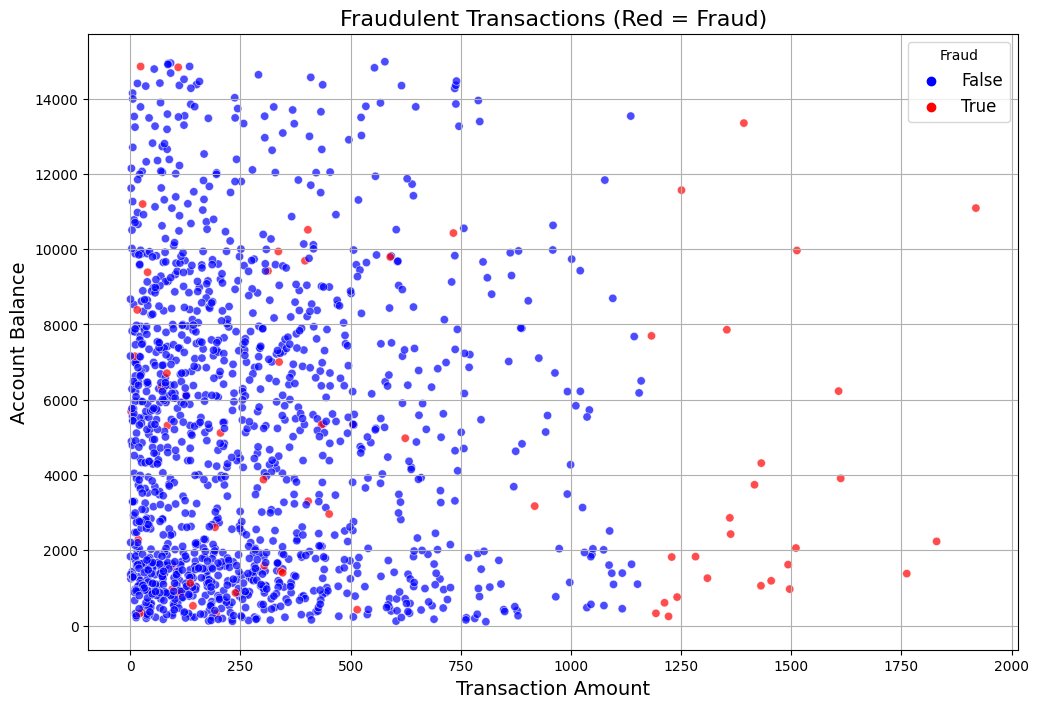

Results saved to /Users/raghav/Downloads/fraud_detection_results.csv


TransactionID AccountID  TransactionAmount     TransactionDate  \
2267      TX002268   AC00416            1360.67 2023-04-19 16:38:41   
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   
486       TX000487   AC00148            1416.69 2023-01-16 17:00:11   
754       TX000755   AC00153              84.34 2023-06-08 16:27:56   
400       TX000401   AC00145             194.85 2023-09-12 16:50:21   
...            ...       ...                ...                 ...   
1363      TX001364   AC00089             204.70 2023-09-21 16:08:00   
837       TX000838   AC00169              39.21 2023-05-10 16:15:31   
1082      TX001083   AC00200             136.05 2023-01-23 16:19:25   
2262      TX002263   AC00279              15.81 2023-03-02 18:36:55   
916       TX000917   AC00272             337.73 2023-05-23 17:12:39   

     TransactionType       Location DeviceID       IP Address MerchantID  \
2267           Debit        Raleigh  D000017   164.75.163.220       M092   
74             Debit   Indianapolis  D000231     193.83.0.183       M036   
486            Debit      Nashville  D000418   219.98.242.240       M015   
754            Debit        Memphis  D000493   200.136.146.93       M039   
400            Debit   Jacksonville  D000601  148.234.210.167       M096   
...              ...            ...      ...              ...        ...   
1363           Debit  Oklahoma City  D000359   141.201.46.191       M032   
837            Debit          Miami  D000059   105.87.212.115       M093   
1082           Debit        Atlanta  D000362    82.115.199.37       M068   
2262           Debit  Oklahoma City  D000606     96.24.89.146       M018   
916            Debit    San Antonio  D000480  219.193.239.152       M065   

     Channel  ...  PreviousTransactionDate  TimeSinceLastTransaction  Fraud  \
2267  Branch  ...      2024-11-04 08:06:27               -48785266.0   True   
74    Branch  ...      2024-11-04 08:06:51               -34270222.0   True   
486      ATM  ...      2024-11-04 08:11:35               -56819484.0   True   
754   Online  ...      2024-11-04 08:09:31               -44466095.0   True   
400   Online  ...      2024-11-04 08:08:01               -36170260.0   True   
...      ...  ...                      ...                       ...    ...   
1363  Branch  ...      2024-11-04 08:10:26               -35395346.0   True   
837      ATM  ...      2024-11-04 08:11:52               -46972581.0   True   
1082  Online  ...      2024-11-04 08:12:00               -56217155.0   True   
2262  Branch  ...      2024-11-04 08:12:06               -52925711.0   True   
916   Online  ...      2024-11-04 08:07:28               -45845689.0   True   

     KMeans_Cluster  KMeans_Distance  KMeans_Fraud  ZScore_Fraud  \
2267              4         1.731135         False          True   
74                4         1.968959         False          True   
486               4         2.067331         False          True   
754               2         2.621315          True          True   
400               2         1.265128         False          True   
...             ...              ...           ...           ...   
1363              2         1.831646         False          True   
837               2         2.075054         False          True   
1082              2         2.417246         False          True   
2262              2         1.987880         False          True   
916               2         0.676190         False          True   

      IsoForest_Score  IsoForest_Fraud  LogReg_Fraud  
2267         0.058479            False          True  
74           0.048990            False         False  
486          0.033061            False          True  
754          0.011297            False         False  
400          0.016680            False          True  
...               ...              ...           ...  
1363        -0.030790             True          True  
837         -0.026706            

In [31]:
# Summary of fraud detection results
print(f"Total Fraudulent Transactions Detected: {data['Fraud'].sum()}")

# Visualize fraudulent transactions
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='TransactionAmount', 
    y='AccountBalance', 
    hue='Fraud', 
    data=data, 
    palette={True: 'red', False: 'blue'}, 
    alpha=0.7
)
plt.title('Fraudulent Transactions (Red = Fraud)', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', fontsize=12)
plt.grid(True)
plt.show()

# Save the results to a CSV file
output_path = '/Users/raghav/Downloads/fraud_detection_results.csv'
data.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

# Filter the DataFrame for rows where 'Fraud' is True
fraud_rows = data[data['Fraud'] == True]

# Print the filtered rows
fraud_rows

In [32]:
# Identify boolean columns
boolean_columns = fraud_rows.select_dtypes(include=['bool']).columns
fraud_rows = fraud_rows.copy()

# Count the number of True values per row
fraud_rows['Threat_Level'] = fraud_rows[boolean_columns].sum(axis=1)-1

# Sort rows by the count of True values in descending order
sorted_data = fraud_rows.sort_values(by='Threat_Level', ascending=False)

# Save the sorted data to a new CSV file
output_path = '/Users/raghav/Downloads/potential_fraudulent_transactions.csv'
sorted_data.to_csv(output_path, index=False)
print(f"Sorted data saved to {output_path}")

# Load the dataset
fraud_file_path = '/Users/raghav/Downloads/potential_fraudulent_transactions.csv'  # Replace with your file path
fr = pd.read_csv(fraud_file_path)

# Display the top rows
print("Top rows with the most True values:")
sorted_data

Sorted data saved to /Users/raghav/Downloads/potential_fraudulent_transactions.csv
Top rows with the most True values:


TransactionID AccountID  TransactionAmount     TransactionDate  \
2149      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
1618      TX001619   AC00305             108.75 2023-10-17 16:09:20   
693       TX000694   AC00011             733.29 2023-03-15 18:42:16   
850       TX000851   AC00124              23.40 2023-02-08 18:27:49   
2445      TX002446   AC00439             403.01 2023-09-04 17:32:35   
...            ...       ...                ...                 ...   
535       TX000536   AC00161            1182.86 2023-12-11 16:06:51   
1156      TX001157   AC00211             917.81 2023-08-30 18:38:56   
2086      TX002087   AC00029            1192.95 2023-12-04 18:30:00   
1514      TX001515   AC00272              71.34 2023-08-28 16:00:00   
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   

     TransactionType        Location DeviceID       IP Address MerchantID  \
2149           Debit        Columbus  D000282      35.67.21.23       M054   
1618           Debit         Houston  D000081  119.163.214.161       M097   
693            Debit  Virginia Beach  D000618    16.51.235.240       M032   
850            Debit         El Paso  D000079     74.58.165.67       M027   
2445           Debit      Washington  D000677    223.32.70.156       M029   
...              ...             ...      ...              ...        ...   
535            Debit          Tucson  D000673     96.24.89.146       M050   
1156           Debit     Kansas City  D000217     42.61.10.112       M047   
2086           Debit       Las Vegas  D000227    71.93.189.160       M068   
1514           Debit           Miami  D000256   188.225.207.71       M021   
74             Debit    Indianapolis  D000231     193.83.0.183       M036   

     Channel  ...  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
2149     ATM  ...               -53101407.0   True               4   
1618     ATM  ...               -33148858.0   True               2   
693      ATM  ...               -51801896.0   True               2   
850      ATM  ...               -54826765.0   True               2   
2445  Online  ...               -36859017.0   True               2   
...      ...  ...                       ...    ...             ...   
535   Online  ...               -28396927.0   True               4   
1156     ATM  ...               -37287050.0   True               4   
2086  Branch  ...               -28993081.0   True               4   
1514  Online  ...               -37469383.0   True               2   
74    Branch  ...               -34270222.0   True               4   

     KMeans_Distance  KMeans_Fraud  ZScore_Fraud  IsoForest_Score  \
2149        3.015050          True          True        -0.009762   
1618        2.938793          True          True        -0.052786   
693         2.851417          True          True        -0.066338   
850         2.687701          True          True        -0.052953   
2445        3.311445          True          True        -0.038969   
...              ...           ...           ...              ...   
535         1.870734         False          True         0.070057   
1156        1.950436         False         False         0.054832   
2086        1.594830         False          True         0.088135   
1514        2.057516         False          True         0.043861   
74          1.968959         False          True         0.048990   

      IsoForest_Fraud  LogReg_Fraud  Threat_Level  
2149             True          True             4  
1618             True          True             4  
693              True          True             4  
850              True          True             4  
2445             True          True             4  
...               ...           ...           ...  
535             False         False             1  
1156            False          True             1  
2086            False         False             1  
1514            False         False  

# FINAL OUTPUT: potential_fraudulent_transactions.csv gives a List of Fraudulent Transactions in the order of their Threat Level. 

Result shows 119/1944 transactions are fraudulent

#### Displaying the top 5 AccountIDs with most number of potential fraud transactions

In [33]:
# Count occurrences of each AccountID
accountid_counts = fr['AccountID'].value_counts()

# Find the most repeated AccountID(s)
most_repeated_accountid = accountid_counts.idxmax()
max_count = accountid_counts.max()

# Display the top repeated AccountID(s)
print(f"The most repeated AccountID is: {most_repeated_accountid} with {max_count} occurrences.")

# Display the top 5 most repeated AccountIDs
print("Top 5 most repeated AccountIDs:")
print(accountid_counts.head())

The most repeated AccountID is: AC00358 with 3 occurrences.
Top 5 most repeated AccountIDs:
AccountID
AC00358    3
AC00272    2
AC00161    2
AC00200    1
AC00312    1
Name: count, dtype: int64


#### Threat Chart

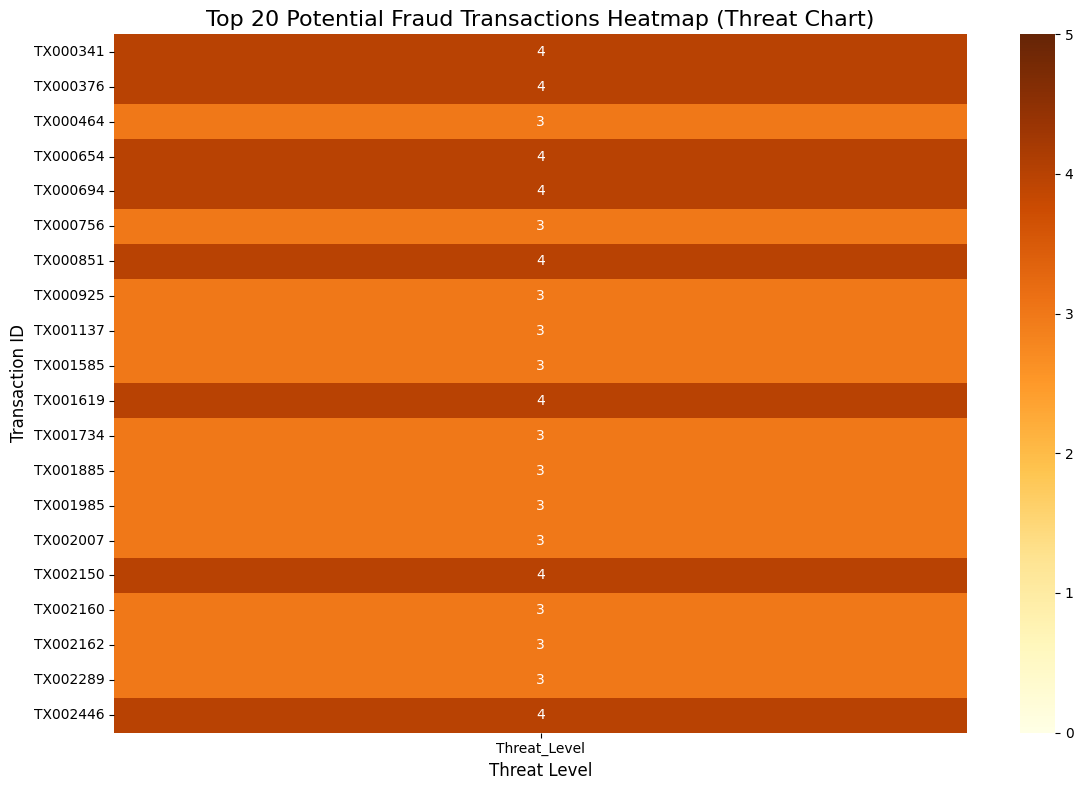

In [34]:
# Select the top 20 rows
top_20_data = fr.head(20)

# Pivot table for heatmap
heatmap_data = top_20_data.pivot_table(
    index='TransactionID', 
    values='Threat_Level'
)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    annot=True,
    cmap="YlOrBr",
    vmin=0,
    vmax=5, 
    cbar=True
)

# Add labels and title
plt.title("Top 20 Potential Fraud Transactions Heatmap (Threat Chart)", fontsize=16)
plt.xlabel("Threat Level", fontsize=12)
plt.ylabel("Transaction ID", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

The fraud detection project successfully combines statistical and machine learning techniques to identify potential debit card fraudulent transactions in a dataset of 1944 records. Through thorough data preprocessing and comprehensive analyses, five anomaly detection methods—K-Means Clustering, Z-Score Analysis, Logistic Regression, and Isolation Forest—were implemented, each contributing unique insights. The results were consolidated into a ThreatLevel metric, enabling a prioritized view of high-risk transactions.

The project not only demonstrates effective detection but also emphasizes interpretability through detailed visualizations and color-coded threat chart. With scalability and practical applicability, this framework can serve as a robust foundation for real-world fraud detection systems for our clients in the finance sector.

Check 'potential_fraudulent_transactions.csv' for the list of suspicious transactions that are flagged

# Clarity on the data being used and produced:

In [43]:
output_path = '/Users/raghav/Downloads/debit_card_transactions_.csv'
sorted_data.to_csv(output_path, index=False)
print("Here is the training data for the Debit Card Fraud Detection Model: \n")
data

Here is the training data for the Debit Card Fraud Detection Model: 



TransactionID AccountID  TransactionAmount     TransactionDate  \
2297      TX002298   AC00219             111.41 2023-12-27 17:18:17   
1511      TX001512   AC00345             288.43 2023-05-08 16:37:53   
2267      TX002268   AC00416            1360.67 2023-04-19 16:38:41   
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   
1556      TX001557   AC00470             170.97 2023-05-01 17:04:30   
...            ...       ...                ...                 ...   
1660      TX001661   AC00459             285.69 2023-12-06 18:15:42   
295       TX000296   AC00272              20.54 2023-08-21 18:09:24   
916       TX000917   AC00272             337.73 2023-05-23 17:12:39   
513       TX000514   AC00469              65.57 2023-04-06 17:24:16   
2392      TX002393   AC00345             429.25 2023-06-12 16:26:36   

     TransactionType      Location DeviceID       IP Address MerchantID  \
2297           Debit       Chicago  D000162    18.72.115.111       M079   
1511           Debit       Phoenix  D000136     7.105.184.86       M075   
2267           Debit       Raleigh  D000017   164.75.163.220       M092   
74             Debit  Indianapolis  D000231     193.83.0.183       M036   
1556           Debit     Nashville  D000259    187.52.200.18       M044   
...              ...           ...      ...              ...        ...   
1660           Debit         Miami  D000132    141.169.67.34       M064   
295            Debit    Fort Worth  D000348   171.101.134.74       M055   
916            Debit   San Antonio  D000480  219.193.239.152       M065   
513            Debit         Miami  D000649     1.198.76.182       M039   
2392           Debit       Seattle  D000199    199.6.127.153       M090   

     Channel  ...  PreviousTransactionDate  TimeSinceLastTransaction  Fraud  \
2297  Branch  ...      2024-11-04 08:10:44               -27010347.0  False   
1511  Branch  ...      2024-11-04 08:09:00               -47143867.0  False   
2267  Branch  ...      2024-11-04 08:06:27               -48785266.0   True   
74    Branch  ...      2024-11-04 08:06:51               -34270222.0   True   
1556  Branch  ...      2024-11-04 08:07:51               -47747001.0  False   
...      ...  ...                      ...                       ...    ...   
1660     ATM  ...      2024-11-04 08:07:59               -28821137.0  False   
295   Branch  ...      2024-11-04 08:07:28               -38066284.0  False   
916   Online  ...      2024-11-04 08:07:28               -45845689.0   True   
513   Online  ...      2024-11-04 08:06:26               -49905730.0  False   
2392  Online  ...      2024-11-04 08:08:36               -44120520.0  False   

     KMeans_Cluster  KMeans_Distance  KMeans_Fraud  ZScore_Fraud  \
2297              0         1.060901         False         False   
1511              1         0.736206         False         False   
2267              4         1.731135         False          True   
74                4         1.968959         False          True   
1556              0         1.310280         False         False   
...             ...              ...           ...           ...   
1660              1         0.817173         False         False   
295               1         0.991868         False         False   
916               2         0.676190         False          True   
513               3         0.700987         False         False   
2392              1         1.140062         False         False   

      IsoForest_Score  IsoForest_Fraud  LogReg_Fraud  
2297         0.225824            False         False  
1511         0.244980            False         False  
2267         0.058479            False          True  
74           0.048990            False         False  
1556         0.135291            False         False  
...               ...              ...           ...  
1660         0.222054            False         False  
295          0.235281            False       

In [44]:
output_path = '/Users/raghav/Downloads/potential_fraudulent_transactions_.csv'
sorted_data.to_csv(output_path, index=False)

print("Here are the results for the Debit Card Fraud Detection Model: \n")
sorted_data

Here are the results for the Debit Card Fraud Detection Model: 



TransactionID AccountID  TransactionAmount     TransactionDate  \
2149      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
1618      TX001619   AC00305             108.75 2023-10-17 16:09:20   
693       TX000694   AC00011             733.29 2023-03-15 18:42:16   
850       TX000851   AC00124              23.40 2023-02-08 18:27:49   
2445      TX002446   AC00439             403.01 2023-09-04 17:32:35   
...            ...       ...                ...                 ...   
535       TX000536   AC00161            1182.86 2023-12-11 16:06:51   
1156      TX001157   AC00211             917.81 2023-08-30 18:38:56   
2086      TX002087   AC00029            1192.95 2023-12-04 18:30:00   
1514      TX001515   AC00272              71.34 2023-08-28 16:00:00   
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   

     TransactionType        Location DeviceID       IP Address MerchantID  \
2149           Debit        Columbus  D000282      35.67.21.23       M054   
1618           Debit         Houston  D000081  119.163.214.161       M097   
693            Debit  Virginia Beach  D000618    16.51.235.240       M032   
850            Debit         El Paso  D000079     74.58.165.67       M027   
2445           Debit      Washington  D000677    223.32.70.156       M029   
...              ...             ...      ...              ...        ...   
535            Debit          Tucson  D000673     96.24.89.146       M050   
1156           Debit     Kansas City  D000217     42.61.10.112       M047   
2086           Debit       Las Vegas  D000227    71.93.189.160       M068   
1514           Debit           Miami  D000256   188.225.207.71       M021   
74             Debit    Indianapolis  D000231     193.83.0.183       M036   

     Channel  ...  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
2149     ATM  ...               -53101407.0   True               4   
1618     ATM  ...               -33148858.0   True               2   
693      ATM  ...               -51801896.0   True               2   
850      ATM  ...               -54826765.0   True               2   
2445  Online  ...               -36859017.0   True               2   
...      ...  ...                       ...    ...             ...   
535   Online  ...               -28396927.0   True               4   
1156     ATM  ...               -37287050.0   True               4   
2086  Branch  ...               -28993081.0   True               4   
1514  Online  ...               -37469383.0   True               2   
74    Branch  ...               -34270222.0   True               4   

     KMeans_Distance  KMeans_Fraud  ZScore_Fraud  IsoForest_Score  \
2149        3.015050          True          True        -0.009762   
1618        2.938793          True          True        -0.052786   
693         2.851417          True          True        -0.066338   
850         2.687701          True          True        -0.052953   
2445        3.311445          True          True        -0.038969   
...              ...           ...           ...              ...   
535         1.870734         False          True         0.070057   
1156        1.950436         False         False         0.054832   
2086        1.594830         False          True         0.088135   
1514        2.057516         False          True         0.043861   
74          1.968959         False          True         0.048990   

      IsoForest_Fraud  LogReg_Fraud  Threat_Level  
2149             True          True             4  
1618             True          True             4  
693              True          True             4  
850              True          True             4  
2445             True          True             4  
...               ...           ...           ...  
535             False         False             1  
1156            False          True             1  
2086            False         False             1  
1514            False         False  

In [45]:
output_path = '/Users/raghav/Downloads/debit_card_transactions_test_data_.csv'
sorted_data.to_csv(output_path, index=False)
print("Here is the test dataset for the Debit Card Fraud Detection Model: \n")
test_data

Here is the test dataset for the Debit Card Fraud Detection Model: 



TransactionID AccountID  TransactionAmount     TransactionDate  \
1324      TX001325   AC00482             686.17 2023-10-03 17:27:25   
397       TX000398   AC00293             131.46 2023-05-15 16:37:12   
472       TX000473   AC00213             423.11 2023-07-25 18:41:02   
178       TX000179   AC00156             237.06 2023-12-18 16:47:17   
55        TX000056   AC00374             316.95 2023-08-04 17:53:40   
...            ...       ...                ...                 ...   
707       TX000708   AC00442             210.45 2023-12-11 16:47:05   
2379      TX002380   AC00443             684.50 2023-07-31 18:52:14   
499       TX000500   AC00325             157.97 2023-06-21 16:00:51   
824       TX000825   AC00319              60.99 2023-08-01 17:14:17   
888       TX000889   AC00176               1.21 2023-08-21 17:19:06   

     TransactionType       Location DeviceID      IP Address MerchantID  \
1324           Debit         Denver  D000103  199.199.60.222       M030   
397            Debit      Charlotte  D000287   146.69.70.214       M006   
472            Debit       Columbus  D000113    64.57.44.102       M055   
178            Debit        Phoenix  D000455    61.95.76.233       M049   
55             Debit           Mesa  D000013   81.102.230.41       M052   
...              ...            ...      ...             ...        ...   
707            Debit      Las Vegas  D000547  144.91.150.133       M011   
2379           Debit     Fort Worth  D000075   190.251.45.32       M035   
499            Debit   Philadelphia  D000635   89.237.88.251       M009   
824            Debit  Oklahoma City  D000651    5.50.152.168       M037   
888            Debit        Atlanta  D000369   96.115.67.230       M039   

     Channel  TransactionDuration  LoginAttempts  AccountBalance  \
1324     ATM                   96              1         2246.15   
397   Branch                  258              1         6642.33   
472      ATM                   47              1          412.78   
178   Online                   46              1         1182.77   
55    Branch                   83              1         1324.03   
...      ...                  ...            ...             ...   
707      ATM                  146              1         1242.49   
2379  Branch                   76              1         6258.63   
499   Branch                  140              1         5529.92   
824   Branch                   58              1         7281.46   
888   Branch                  196              1         7542.74   

     PreviousTransactionDate  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
1324     2024-11-04 08:07:37               -34353612.0  False               3   
397      2024-11-04 08:11:30               -46539258.0  False               0   
472      2024-11-04 08:10:58               -40397396.0  False               4   
178      2024-11-04 08:07:50               -27789633.0  False               4   
55       2024-11-04 08:09:15               -39536135.0  False               4   
...                      ...                       ...    ...             ...   
707      2024-11-04 08:06:24               -28394359.0  False               4   
2379     2024-11-04 08:10:14               -39878280.0  False               3   
499      2024-11-04 08:10:06               -43344555.0  False               4   
824      2024-11-04 08:07:51               -39797614.0  False               1   
888      2024-11-04 08:11:34               -38069548.0  False               0   

      KMeans_Distance  KMeans_Fraud  
1324         0.846230         False  
397          0.897647         False  
472          1.093060         False  
178          0.647288         False  
55           0.531340         False  
...               ...           ...  
707          0.936325         False  
2379         1.057741         False  
499          1.130359         False  
824          0.929811         False  
888          1.170859         False  

[156

# TESTING:

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.91      0.96        47
        True       0.00      0.00      0.00         0

    accuracy                           0.91        47
   macro avg       0.50      0.46      0.48        47
weighted avg       1.00      0.91      0.96        47



/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


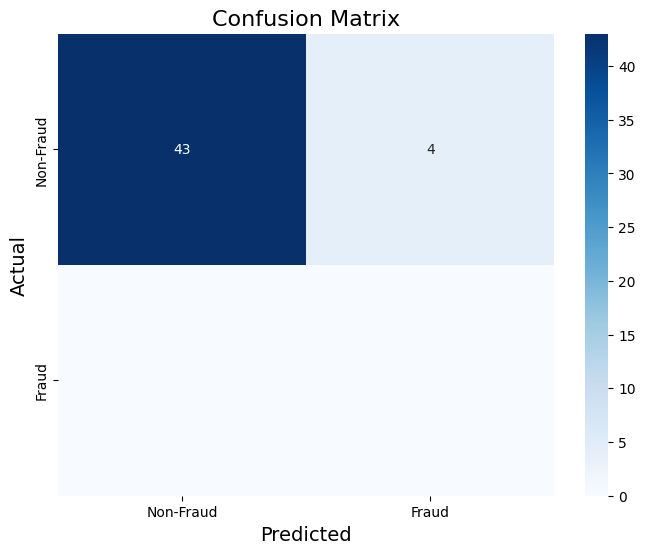

In [47]:
test_data
features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
target = 'Fraud'

# Prepare the dataset
X1 = test_data[features]
y1 = test_data[target]

# Standardize the features
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.3, random_state=42)

y1_pred = log_reg.predict(X1_test)


# Evaluate model performance
print("Classification Report:")
print(classification_report(y1_test, y1_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y1_test, y1_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()